# Fraud Detection

## Import required modules

In [73]:
get_ipython().magic(u'matplotlib inline')
from __future__ import division
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd
import seaborn as sns
from currency_converter import CurrencyConverter
import itertools
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, auc, precision_recall_curve, accuracy_score, f1_score, confusion_matrix, average_precision_score
import pickle
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
import graphviz
from sklearn.decomposition import PCA

## Read and preview data

We read the `data_for_student_case.csv` file and preview the data.

In [74]:
data = pd.read_csv('data/data_for_student_case.csv')
data.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [75]:
data.dtypes

txid                              int64
bookingdate                      object
issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                     object
shoppercountrycode               object
shopperinteraction               object
simple_journal                   object
cardverificationcodesupplied     object
cvcresponsecode                   int64
creationdate                     object
accountcode                      object
mail_id                          object
ip_id                            object
card_id                          object
dtype: object

In [76]:
for x in data.columns:
    unique_values = set(data[x])
    if len(unique_values) < 100:
        print x,": ", unique_values


txvariantcode :  set(['visasignature', 'visaplatinum', 'mc', 'visacorporate', 'visagold', 'visaclassic', 'mcdebit', 'electron', 'visa', 'visabusiness', 'visadebit', 'visapurchasing', 'vpay', 'mccredit', 'cirrus'])
currencycode :  set(['MXN', 'SEK', 'AUD', 'GBP', 'NZD'])
shopperinteraction :  set(['ContAuth', 'Ecommerce', 'POS'])
simple_journal :  set(['Refused', 'Settled', 'Chargeback'])
cardverificationcodesupplied :  set([False, True, nan])
cvcresponsecode :  set([0, 1, 2, 3, 5])
accountcode :  set(['UKAccount', 'APACAccount', 'SwedenAccount', 'MexicoAccount'])


In [77]:
data.describe() #the only relevant desciption is the amount attribute

,txid,bin,amount,cvcresponsecode
count,290382.000000,290242.000000,2.903820e+05,290382.000000
mean,279916.750673,485254.586238,2.936462e+04,0.769004
std,138437.214796,37015.528140,6.829927e+04,0.508933
min,1.000000,400000.000000,5.000000e+01,0.000000
25%,218232.250000,462239.000000,4.400000e+03,0.000000
50%,304071.500000,475139.000000,7.095000e+03,1.000000
75%,387592.750000,518652.000000,1.589500e+04,1.000000
max,482734.000000,676883.000000,2.785840e+06,5.000000


## Preprocessing

Some preprocessing steps that we try to apply are:
* Remove the `refused` transactions, because their fraudulent ambiguity
* Transform creationdate to pandas datetime
* Reduce the possible number of CVC response code (as it is 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked) to 0, 1, and 3
* Map float columns which supposed to be categorical / identifier (`bin` and `cvcresponsecode`)
* Convert to EURO
* Assign fraudulent label based on `simple_journal` attribute (fraudulent = 1 if simple_journal='chargeback', else fraudulent = 0)

### Remove 'refused' transactions

In [78]:
data_preproc = data.loc[data['simple_journal'] != 'Refused'].copy()
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Transform date to pandas datetime

In [79]:
data_preproc['creationdate'] = pd.to_datetime(data_preproc['creationdate'])
# save month, date, and weekday
data_preproc['creation_month'] = data_preproc.creationdate.dt.month
data_preproc['creation_month'] = data_preproc['creation_month'].astype('category')
data_preproc['creation_weekday'] = data_preproc.creationdate.dt.weekday
data_preproc['creation_weekday'] = data_preproc['creation_weekday'].astype('category')
data_preproc['creation_day'] = data_preproc.creationdate.dt.day
data_preproc['creation_day'] = data_preproc['creation_day'].astype('category')
data_preproc['creation_hour'] = data_preproc.creationdate.dt.hour
data_preproc['creation_hour'] = data_preproc['creation_hour'].astype('category')

# don't need to process booking date, will be removed anyway:
# data_preproc['bookingdate'] = pd.to_datetime(data_preproc['bookingdate'])
# convert datetime to timestamp
# data_preproc['ts'] = data_preproc.creationdate.values.astype(np.int64) // 10 ** 9
# print (data_preproc)

### Map cvcresponsecode with value 3-6 to 3

In [80]:
data_preproc['cvcresponsecode'] = map(lambda x: 3 if int(x) >= 3 else int(x), data_preproc['cvcresponsecode'])

### Map to categorical and object (for identifier) datatype

In [81]:
data_preproc['bin'] = data_preproc['bin'].astype(int)
data_preproc['bin'] = data_preproc['bin'].astype(str)
data_preproc['txid'] = data_preproc['txid'].astype(str)
for category_column in ["issuercountrycode","txvariantcode", "bin", "currencycode","shopperinteraction","simple_journal","cardverificationcodesupplied","cvcresponsecode","accountcode", "shoppercountrycode"]:  
    data_preproc[category_column] = data_preproc[category_column].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                             object
issuercountrycode                     category
txvariantcode                         category
bin                                   category
amount                                 float64
currencycode                          category
shoppercountrycode                    category
shopperinteraction                    category
simple_journal                        category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
creation_month                        category
creation_weekday                      category
creation_day                          category
creation_hour                         category
dtype: object

### Convert amount to EURO currencies

In [82]:
currency_converter = CurrencyConverter()
data_preproc['amount_euro'] = map(lambda x,y: currency_converter.convert(x,y, 'EUR'), data_preproc['amount'],data_preproc['currencycode'])
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,creationdate,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,creation_hour,amount_euro
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,Chargeback,...,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,7,2,1,23,2809.743914
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,Chargeback,...,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,7,3,2,4,1946.875027
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,Chargeback,...,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,7,3,2,14,6499.700814
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,Chargeback,...,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,7,4,3,7,4765.290991
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,Chargeback,...,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,7,2,8,18,3898.086079


### Apply fraudulent label

In [83]:
data_preproc['is_fraud'] = data_preproc.apply(lambda x: 1 if x['simple_journal'] == "Chargeback" else 0, axis=1)
# remove the simple_journal column
data_preproc = data_preproc.drop(['simple_journal'],axis=1)
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,...,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,creation_hour,amount_euro,is_fraud
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,...,MexicoAccount,email68370,ip111778,card184798,7,2,1,23,2809.743914,1
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,...,MexicoAccount,email101299,ip78749,card151595,7,3,2,4,1946.875027,1
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,...,MexicoAccount,email278604,ip70594,card242142,7,3,2,14,6499.700814,1
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,True,...,MexicoAccount,email47409,ip113648,card181744,7,4,3,7,4765.290991,1
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,True,...,MexicoAccount,email205501,ip83553,card97271,7,2,8,18,3898.086079,1


In [84]:
data_preproc['is_fraud'] = data_preproc['is_fraud'].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                             object
issuercountrycode                     category
txvariantcode                         category
bin                                   category
amount                                 float64
currencycode                          category
shoppercountrycode                    category
shopperinteraction                    category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
creation_month                        category
creation_weekday                      category
creation_day                          category
creation_hour                         category
amount_euro                            float64
is_fraud     

### Remove bookingdate
Certain bookingdate indicates that the transaction is indeed fraudulent, so we may not use it for training our classifier

In [85]:
data_preproc = data_preproc.drop(['bookingdate'],axis=1)
data_preproc.head()

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,creation_hour,amount_euro,is_fraud
0,1,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,0,...,MexicoAccount,email68370,ip111778,card184798,7,2,1,23,2809.743914,1
1,2,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,0,...,MexicoAccount,email101299,ip78749,card151595,7,3,2,4,1946.875027,1
2,3,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,0,...,MexicoAccount,email278604,ip70594,card242142,7,3,2,14,6499.700814,1
3,4,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,True,0,...,MexicoAccount,email47409,ip113648,card181744,7,4,3,7,4765.290991,1
4,5,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,True,0,...,MexicoAccount,email205501,ip83553,card97271,7,2,8,18,3898.086079,1


## Visualization Task
We try the following visualization:
* Distribution histogram
* Line chart
* Heat map

### Distribution histogram

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


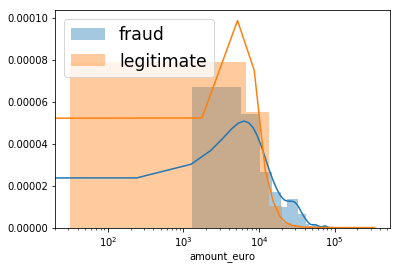

In [35]:
fraud = data_preproc.loc[data_preproc['is_fraud'] == 1]
non_fraud = data_preproc.loc[data_preproc['is_fraud'] == 0]
plt.figure("Amount Distribution (Fraud")
fraud_plot = sns.distplot(fraud['amount_euro'], label="fraud")
fraud_plot.set_xscale('log')
non_fraud_plot = sns.distplot(non_fraud['amount_euro'], label="legitimate")
non_fraud_plot.set_xscale('log')
plt.legend(fontsize="xx-large")
plt.show()

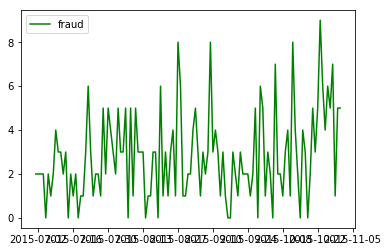

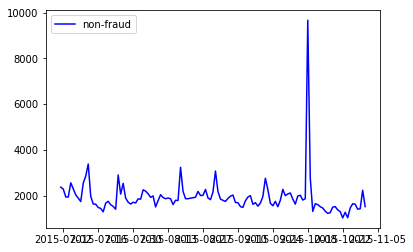

In [36]:
temp_fraud = fraud.set_index('creationdate').resample('1D').count()['txid']
x_fraud = temp_fraud.index
y_fraud = temp_fraud.values

temp_non_fraud = non_fraud.set_index('creationdate').resample('1D').count()['txid']
x_non_fraud = temp_non_fraud.index
y_non_fraud = temp_non_fraud.values


plt.figure()
plt.plot(x_fraud, y_fraud, 'g', label="fraud");
plt.legend()
plt.show()

plt.figure()
plt.plot(x_non_fraud, y_non_fraud,  'b', label="non-fraud");
plt.legend()
plt.show()

### Heat map

We try to plot a heat map in regards of percentage of fraudulent transaction

In [37]:
def fraud_heatmap(column_name_a, column_name_b, frac=True):
    # column_name_a = 'currencycode'
    # column_name_b = 'accountcode'

    x_axis = list(data_preproc[column_name_a][data_preproc.is_fraud == 1].unique())
    y_axis = list(data_preproc[column_name_b][data_preproc.is_fraud == 1].unique())
    values = []

    length_x = len(x_axis)
    length_y = len(y_axis)
    x_axis = np.repeat(x_axis, length_y)
    y_axis = y_axis*length_x


    for combination in zip(x_axis, y_axis):
        # number of fraud
        num_fraud = len(fraud.loc[(fraud[column_name_a] == combination[0]) & (fraud[column_name_b] == combination[1])])
        num_total = len(data_preproc.loc[(data_preproc[column_name_a] == combination[0]) & (data_preproc[column_name_b] == combination[1])])
        #num_total = len(data_preproc)
        
        if frac:
            if num_total == 0:
                values.append(0)
            else:
                values.append(num_fraud / float(num_total))
        else: 
            values.append(num_fraud)

    df = pd.DataFrame({column_name_a: x_axis, column_name_b: y_axis, 'value': values })

    # plot it
    df_wide=df.pivot_table( index=column_name_a, columns=column_name_b, values='value' )
    sns.set(rc={"figure.figsize": (10, 10)})
    sns.heatmap( df_wide, cmap="Blues", annot=True)

In [38]:
# select categorical columns
categorical_columns = [x for x in data_preproc.columns if hasattr(data_preproc[x], 'cat') and x != 'bin']
# remove is_fraud
categorical_columns = categorical_columns[:-1]

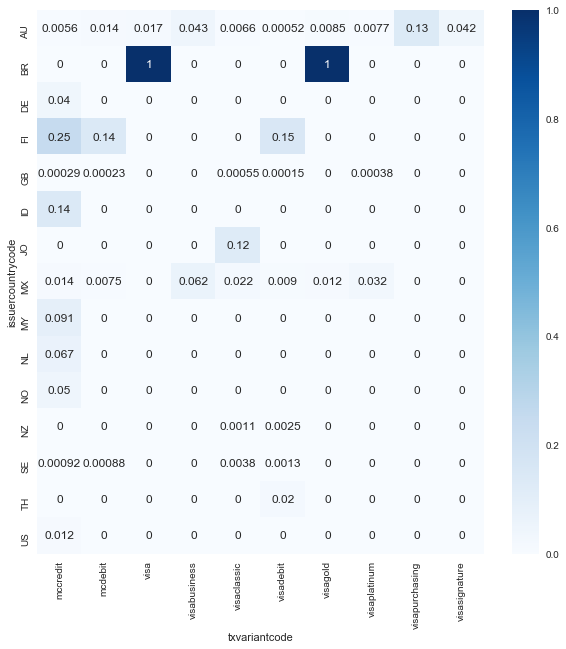

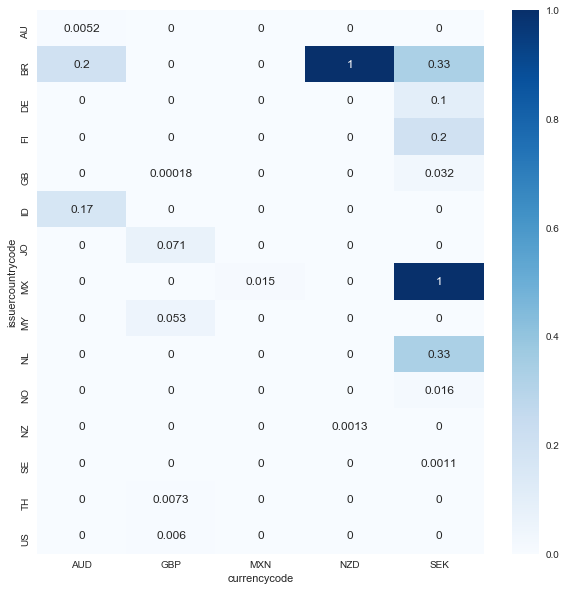

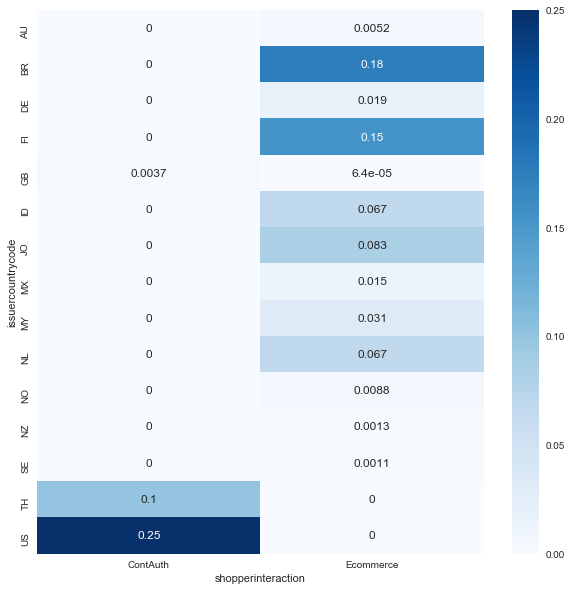

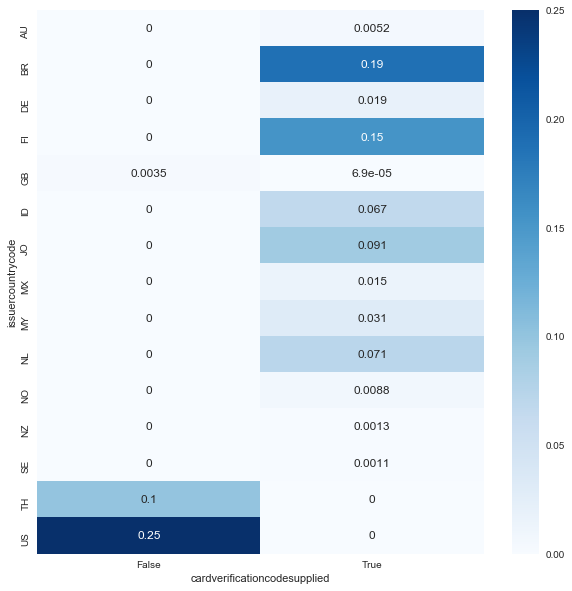

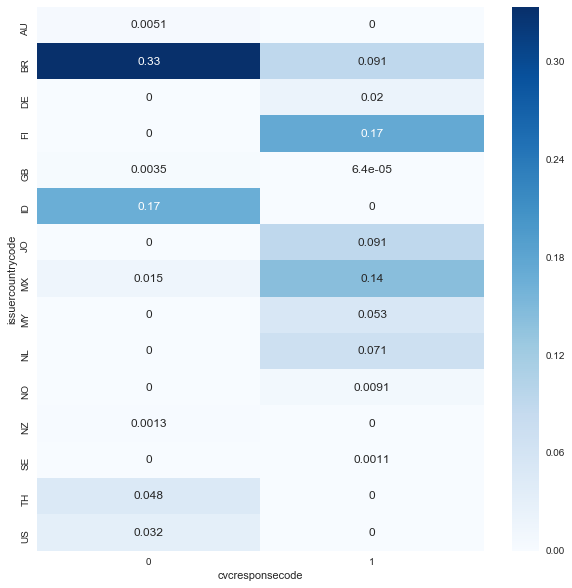

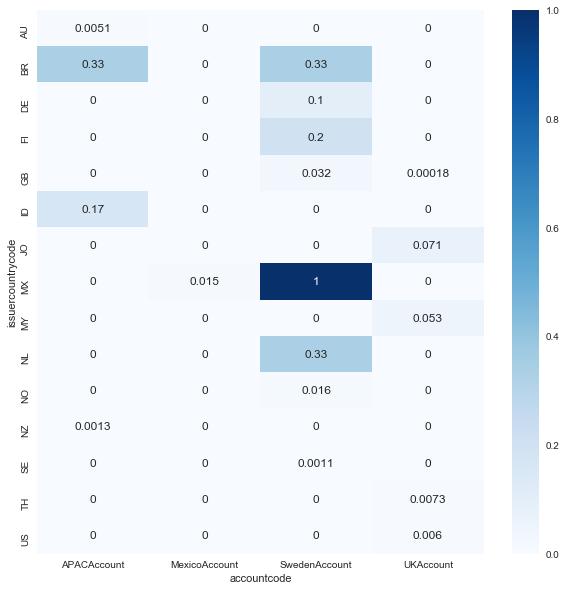

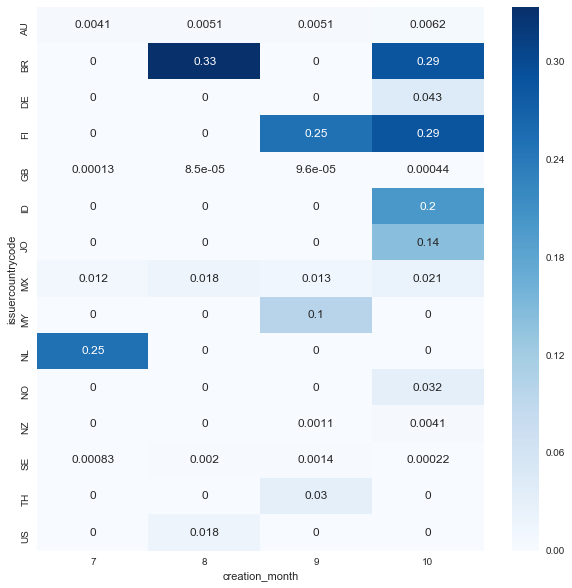

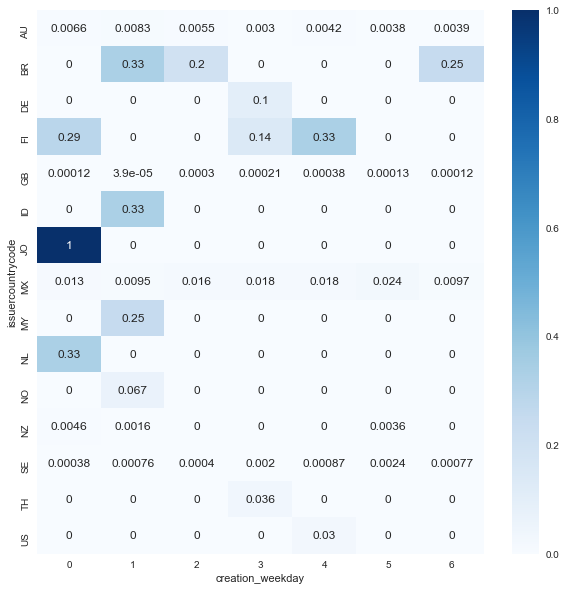

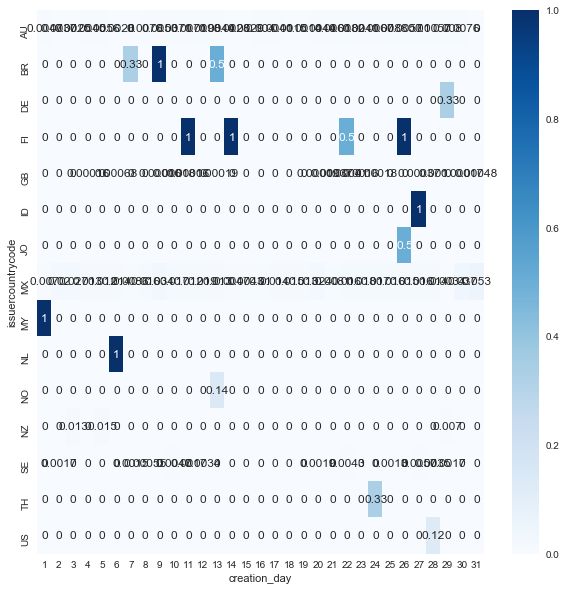

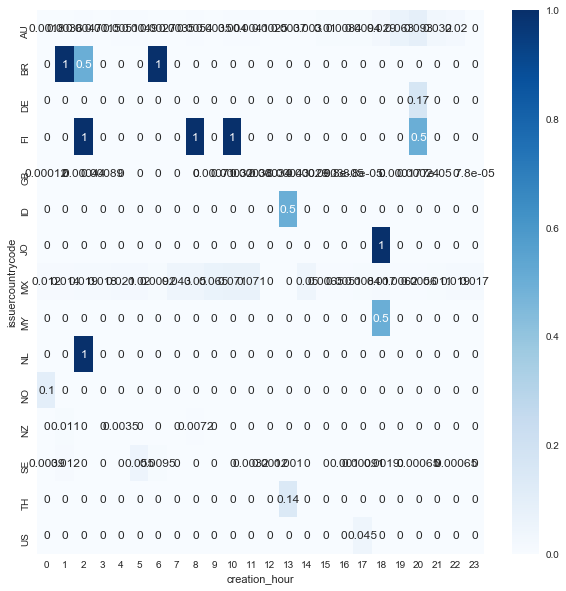

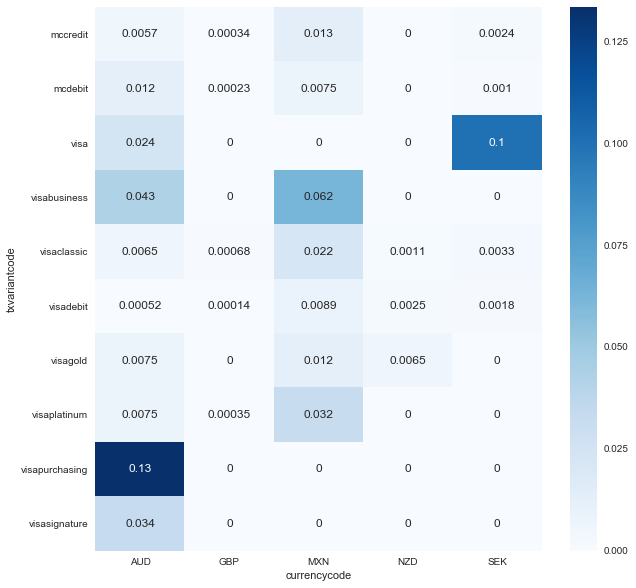

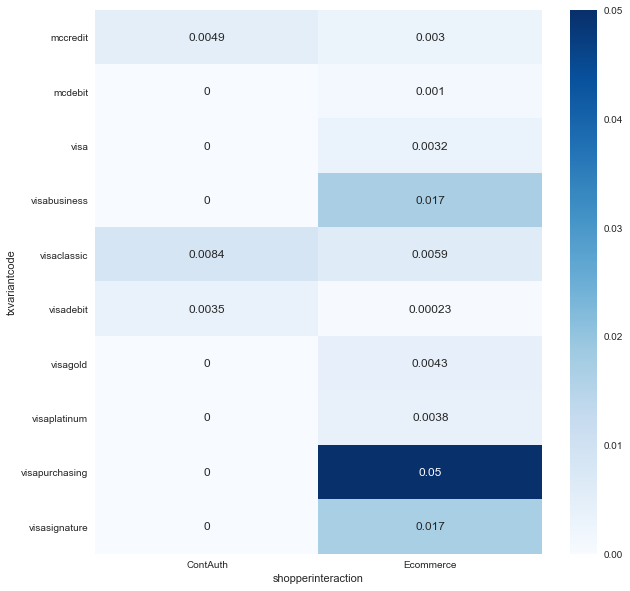

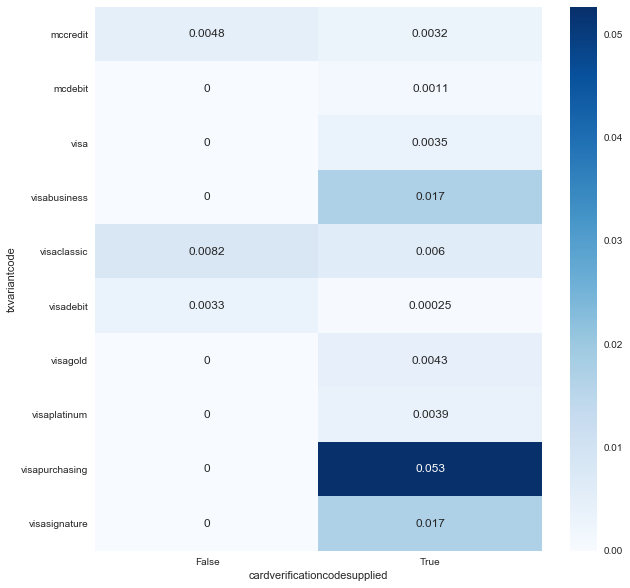

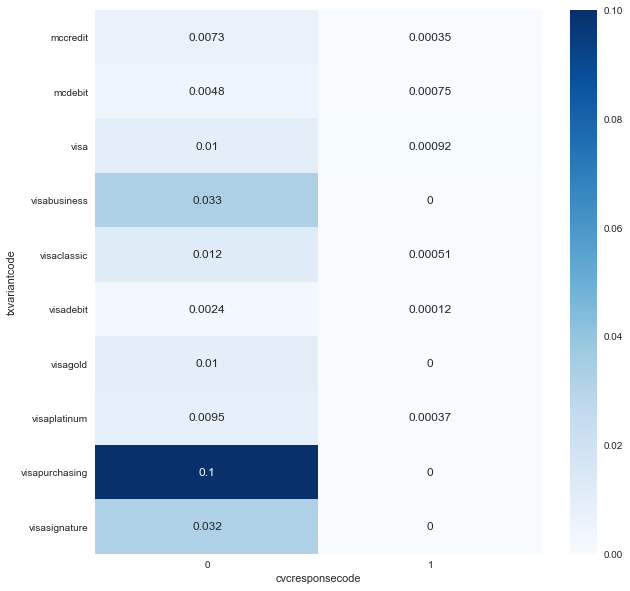

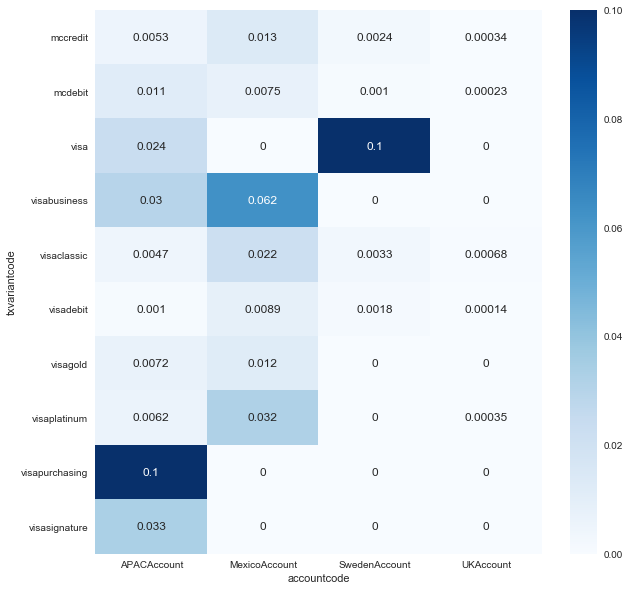

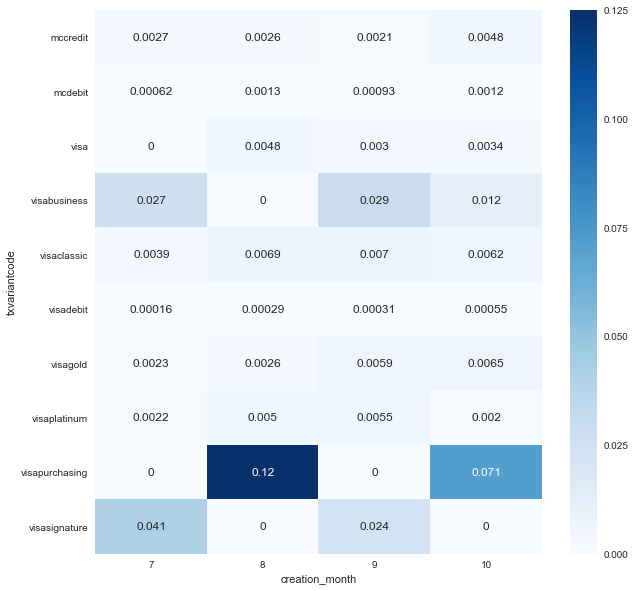

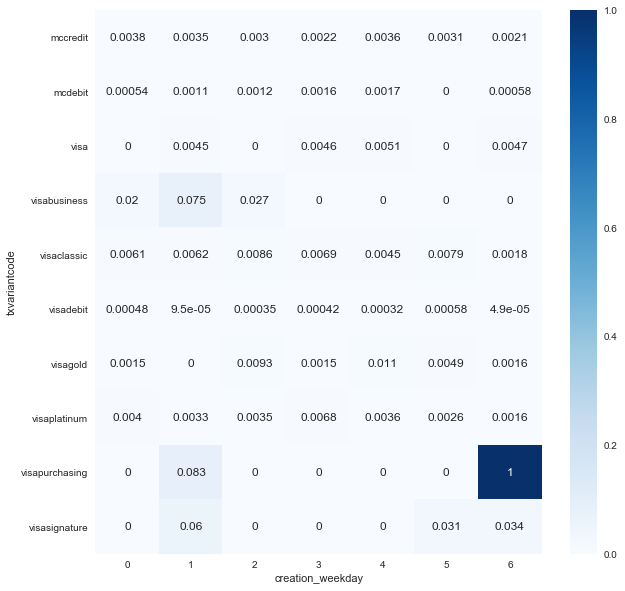

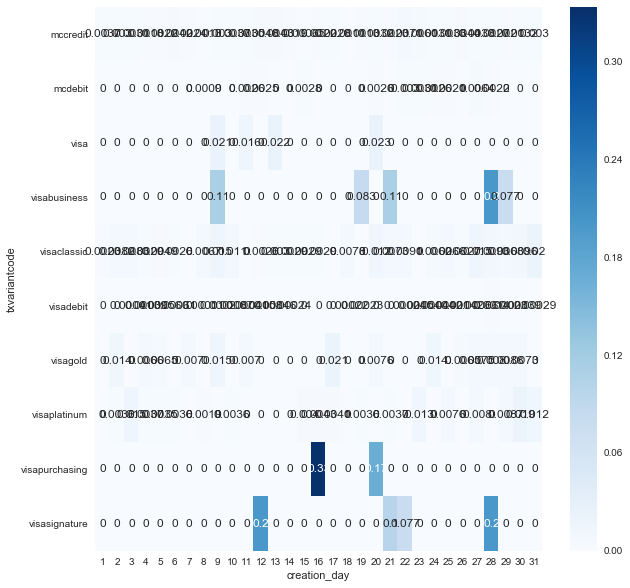

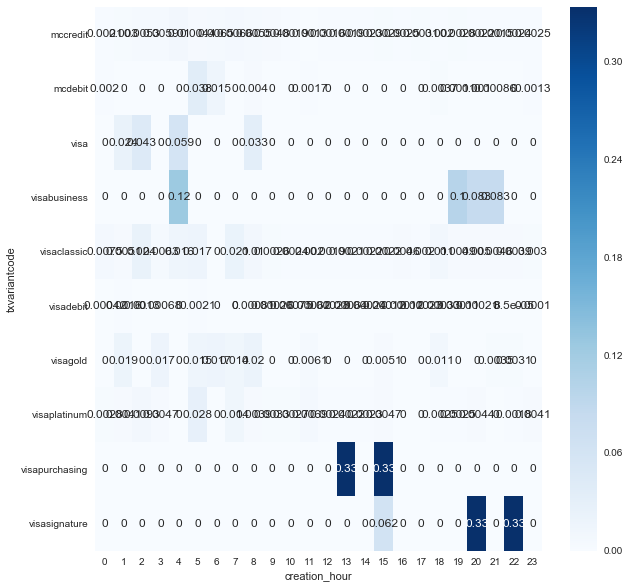

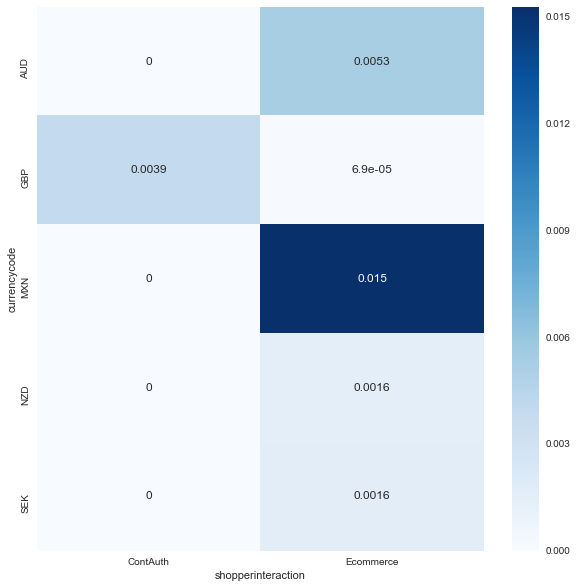

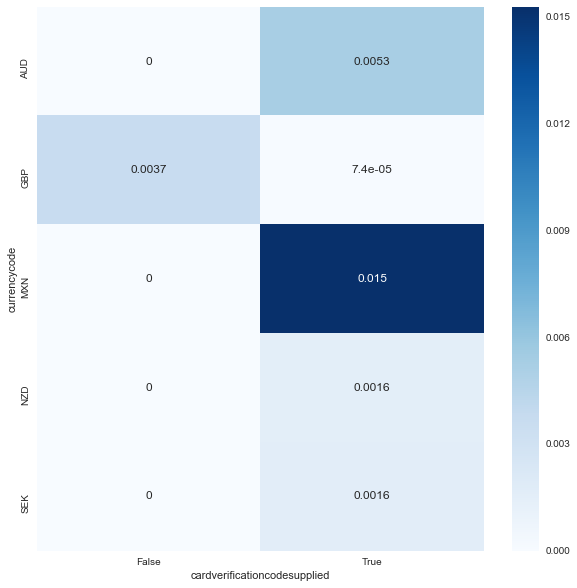

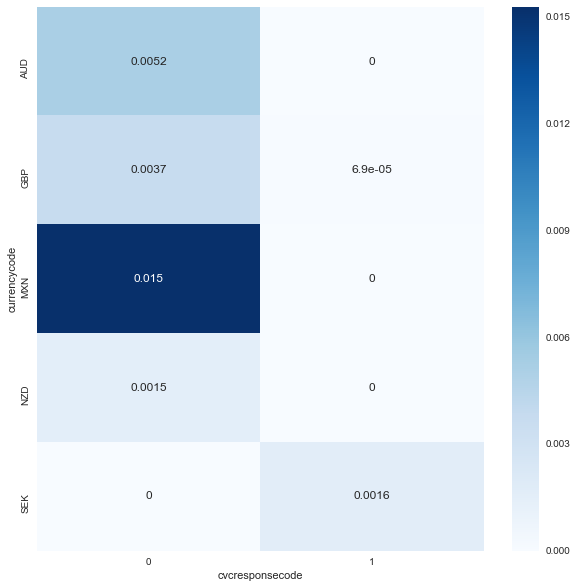

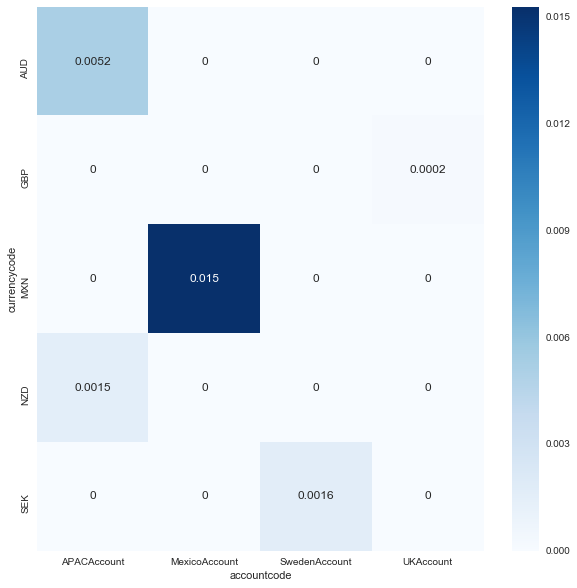

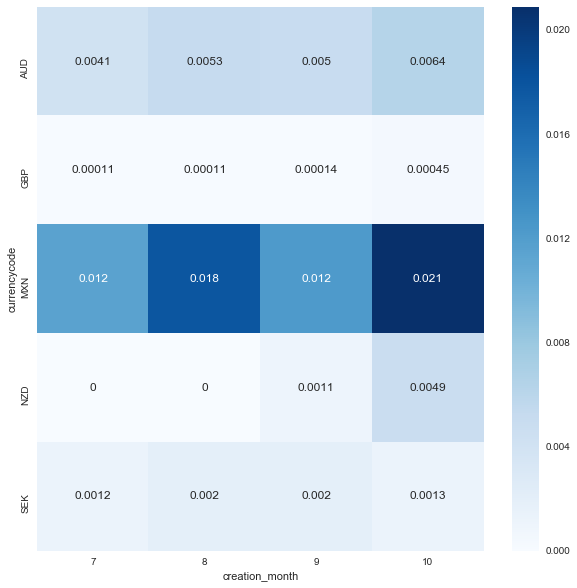

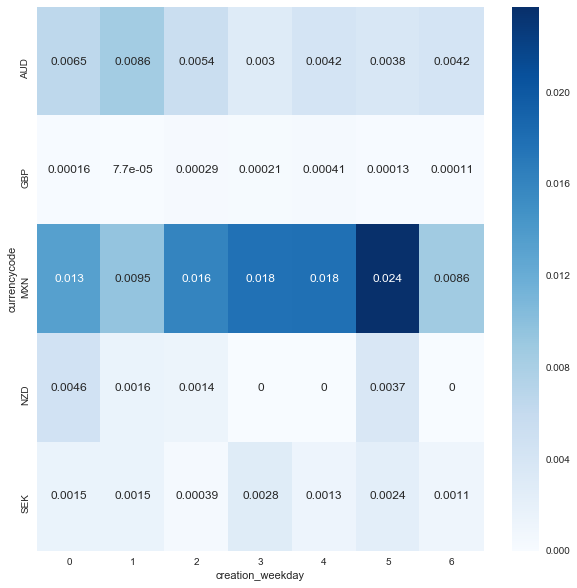

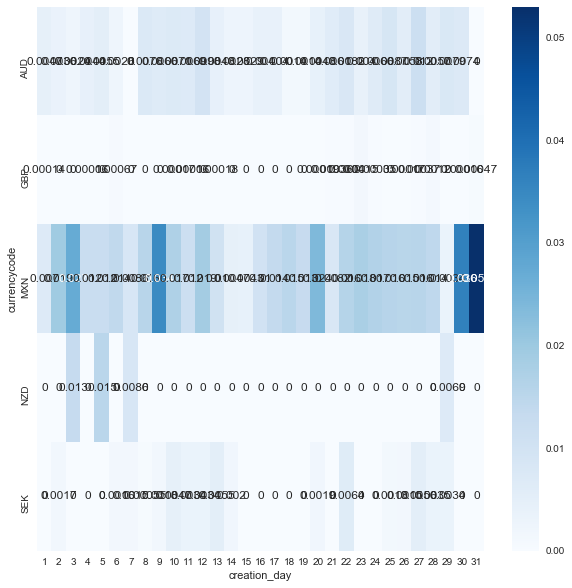

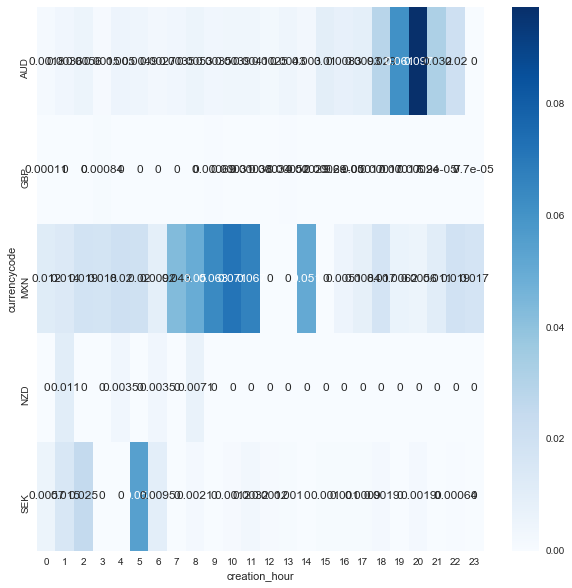

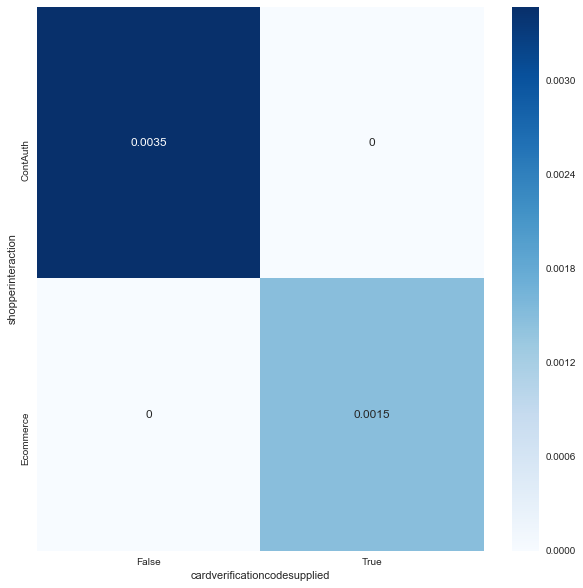

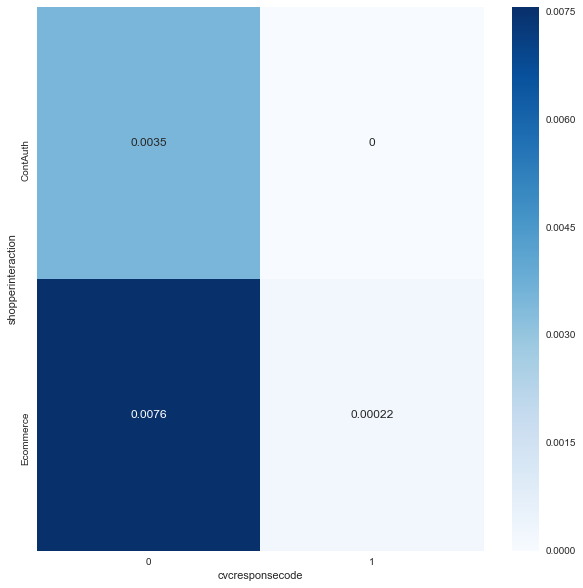

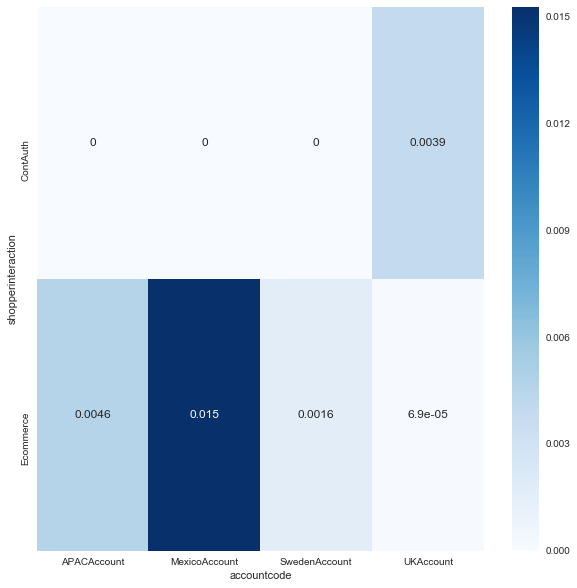

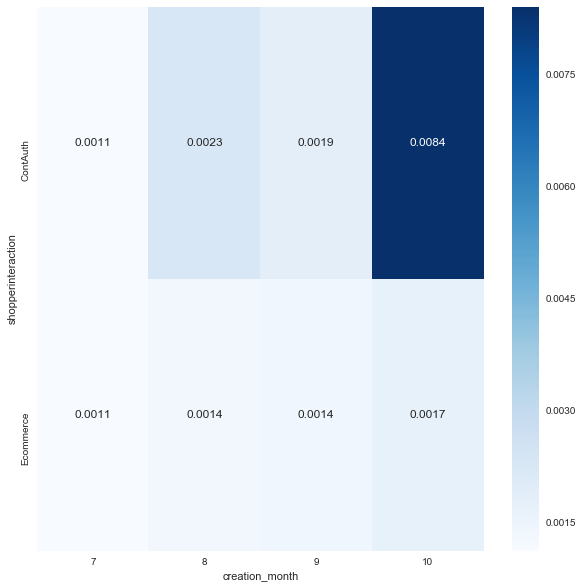

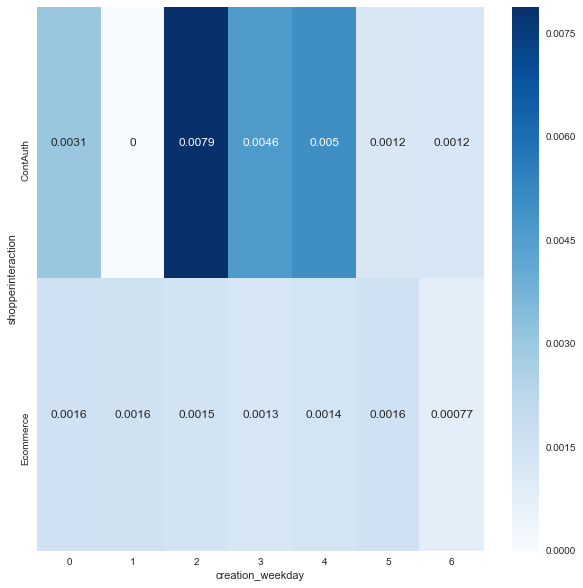

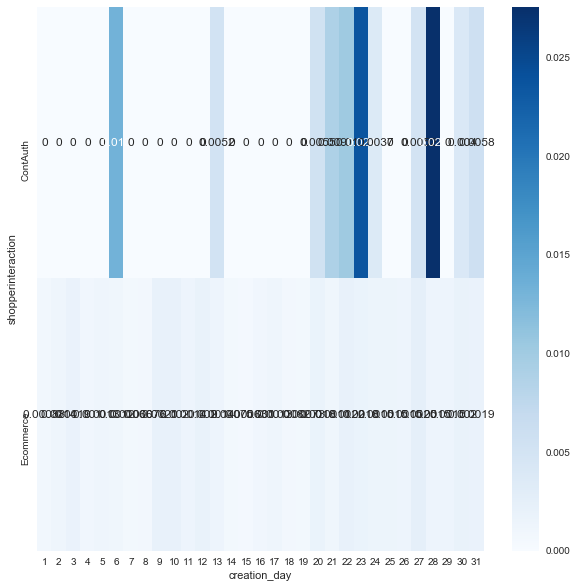

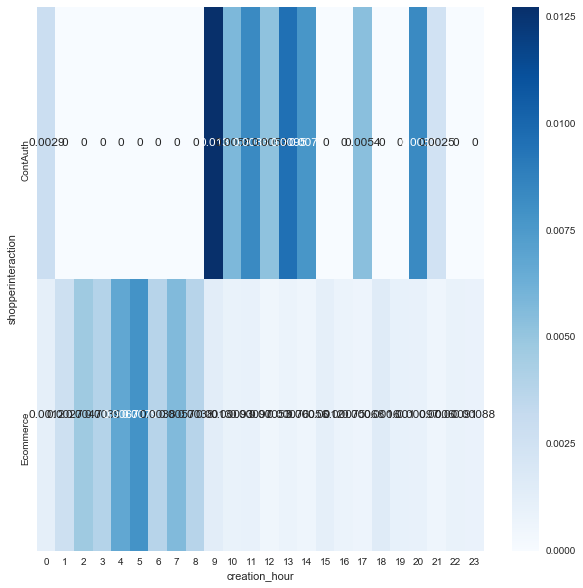

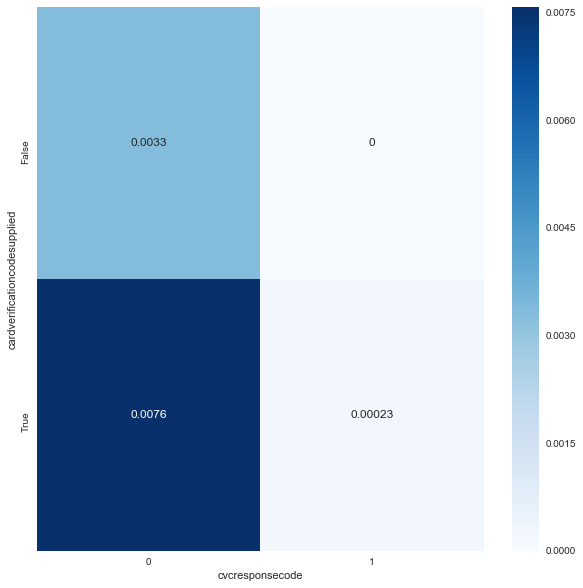

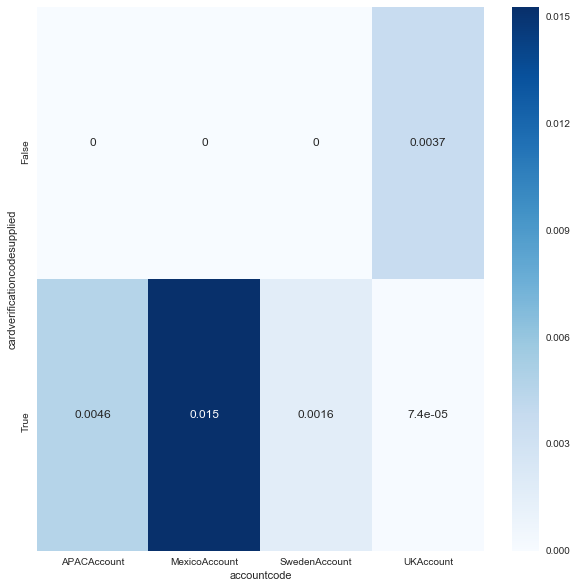

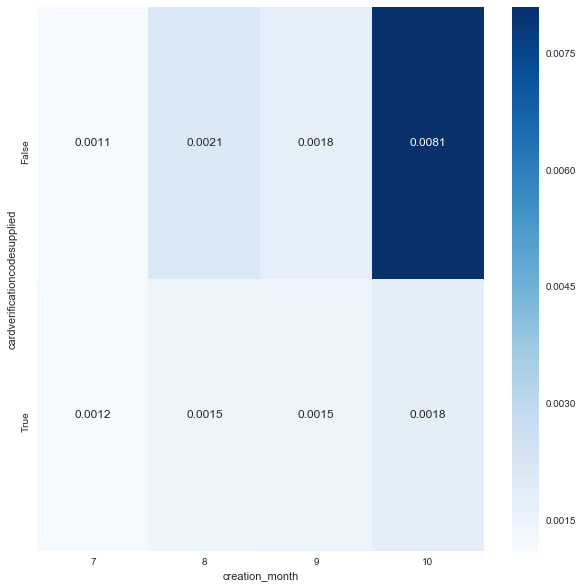

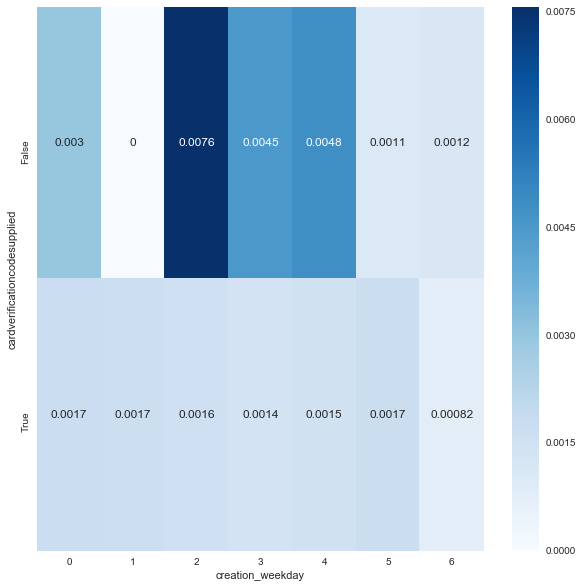

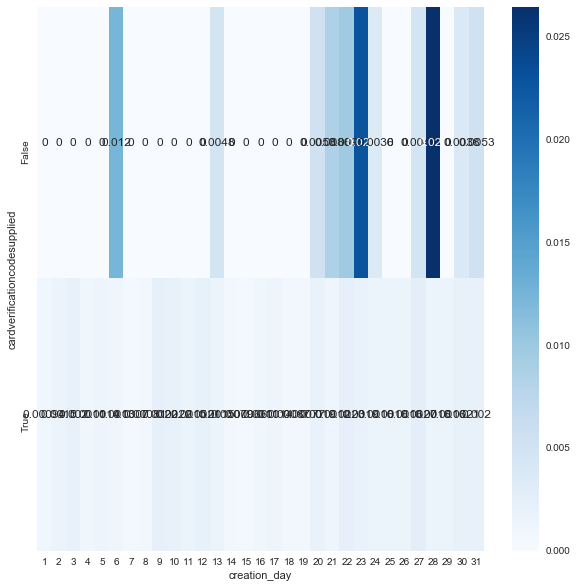

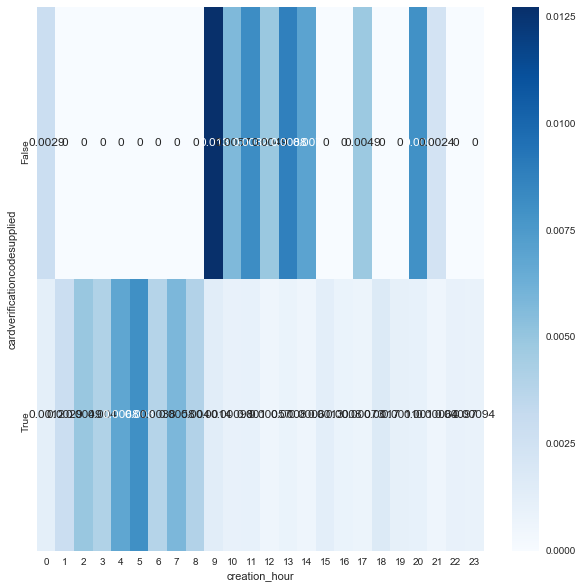

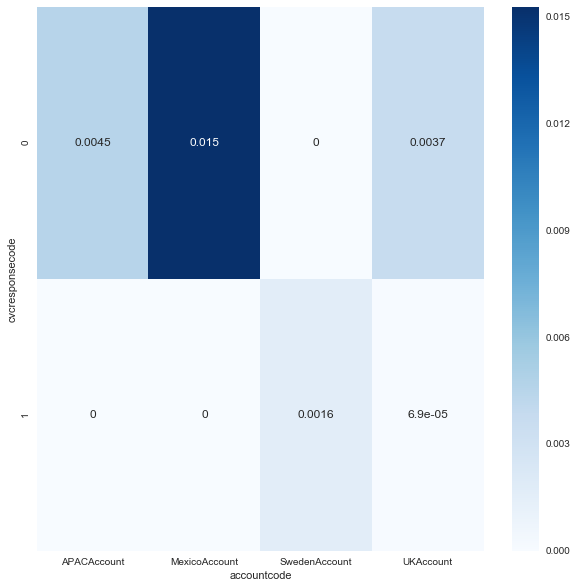

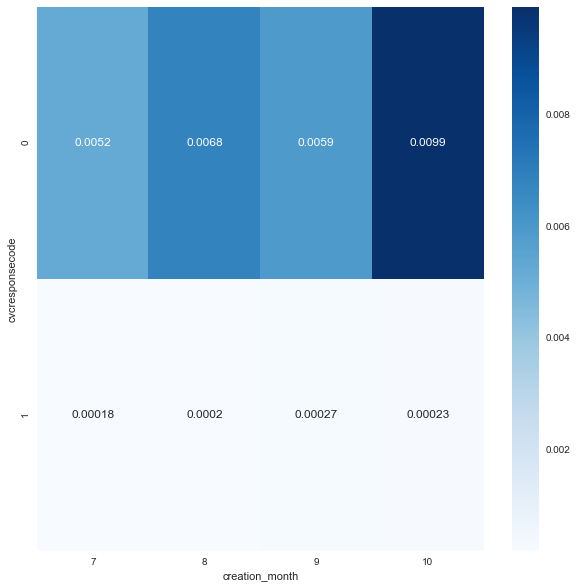

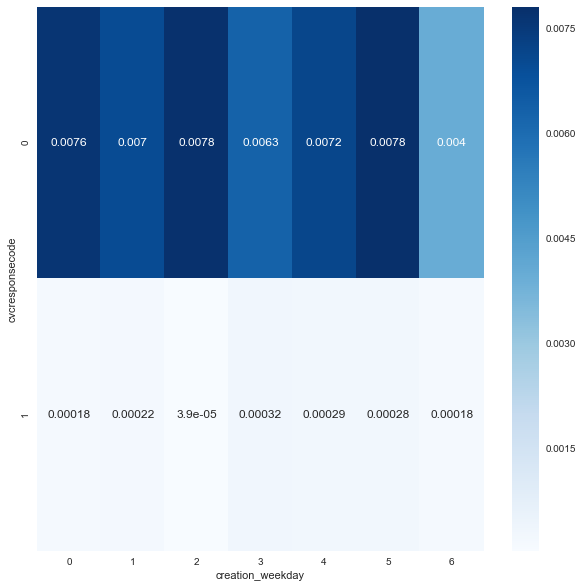

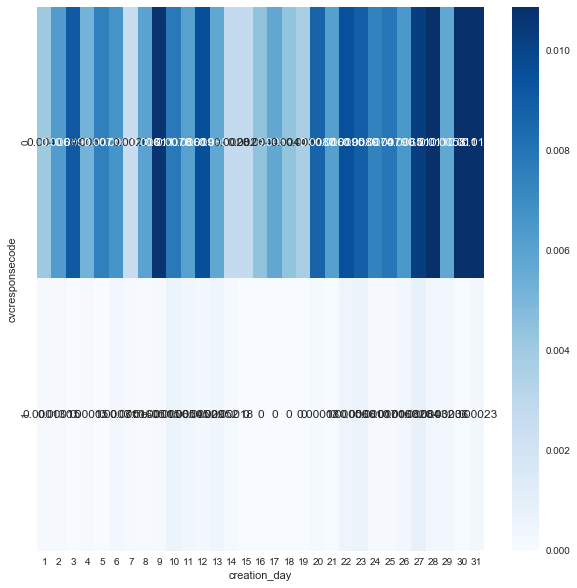

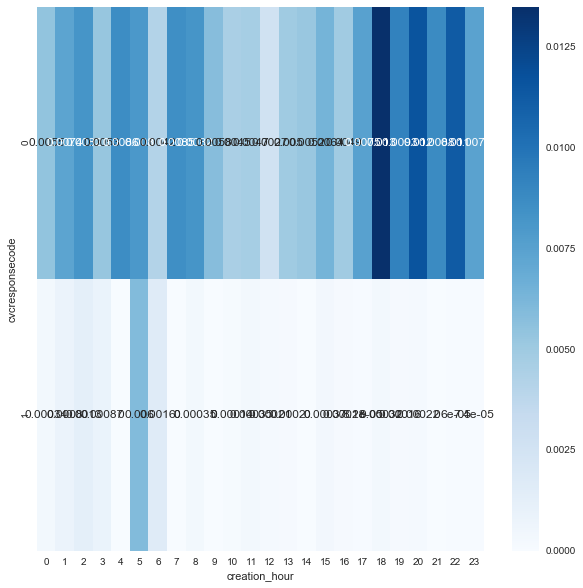

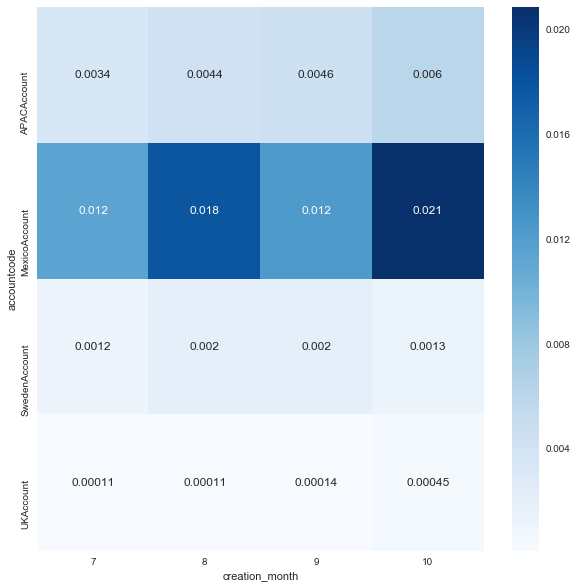

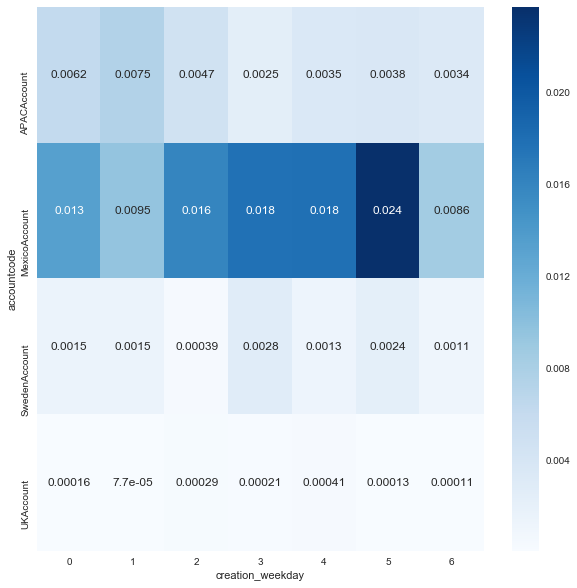

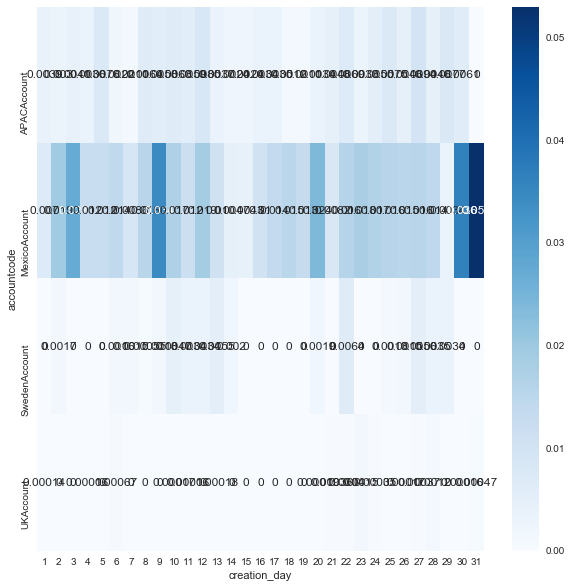

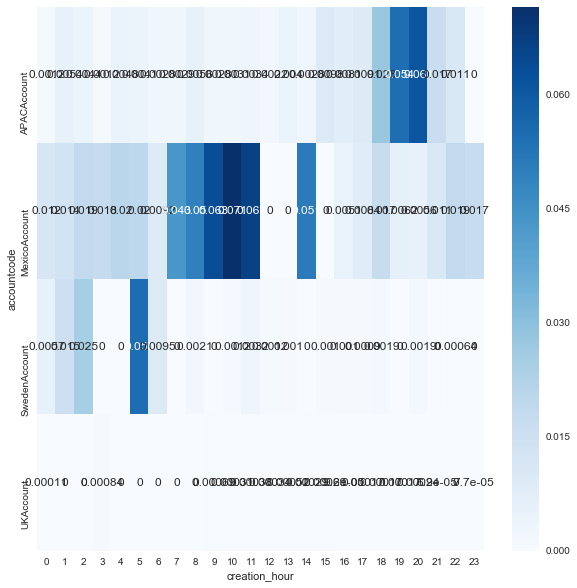

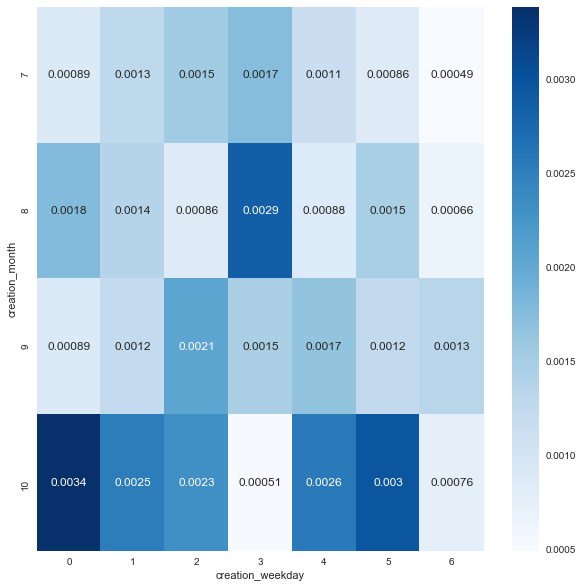

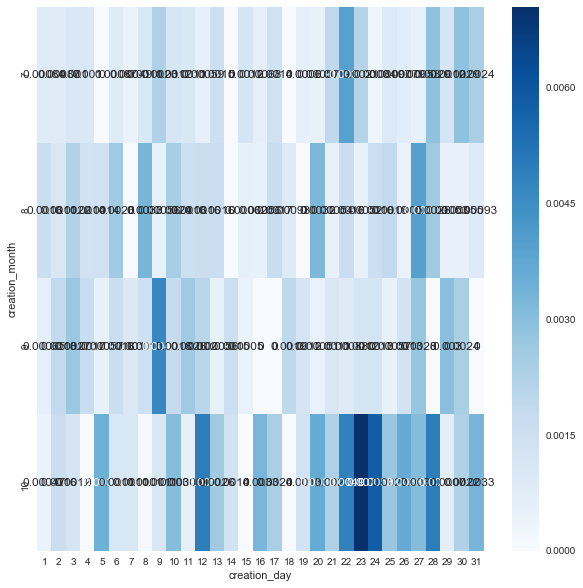

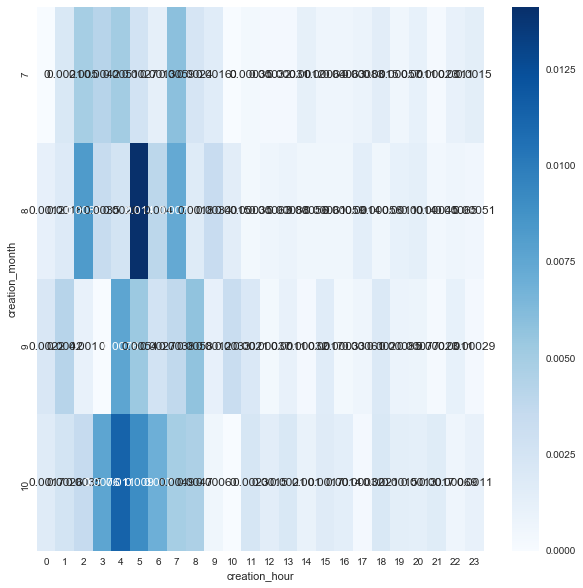

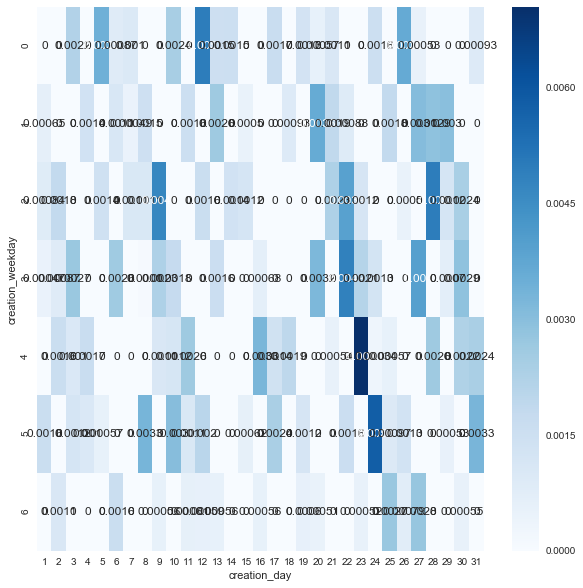

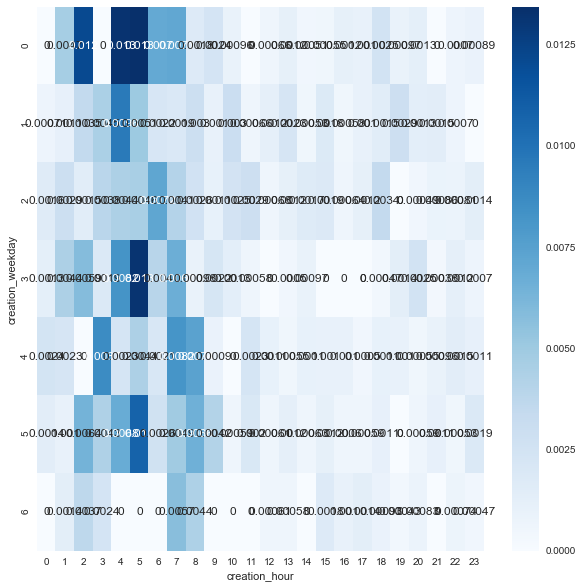

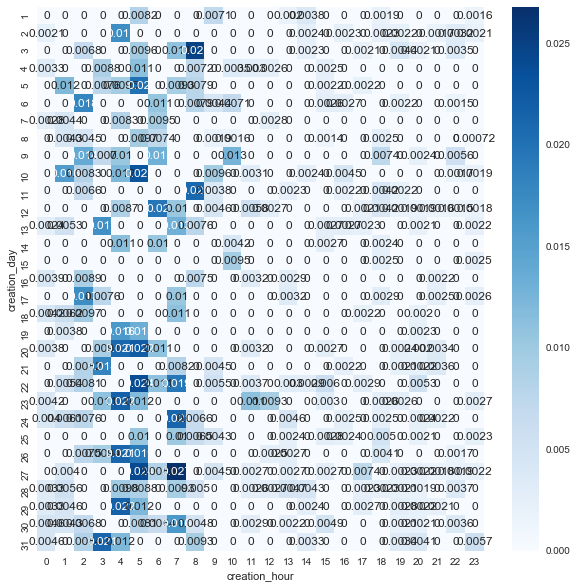

In [39]:
for combination in list(itertools.combinations(categorical_columns,2)):
    fraud_heatmap(combination[0], combination[1], frac=True)
    plt.show()

In [42]:
data_preproc[(data_preproc.currencycode == "SEK") & (data_preproc.issuercountrycode == "MX")]

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,creation_hour,amount_euro,is_fraud
266072,452360,MX,mccredit,547046,620000.0,SEK,SE,Ecommerce,True,1,...,SwedenAccount,email77101,ip174481,card200013,9,6,13,15,62537.825298,1


## Imbalance Task

First let's see how imbalance is the fraud vs non-fraud transactions

In [29]:
data_preproc.is_fraud.value_counts()

0    236691
1       345
Name: is_fraud, dtype: int64

Let's try to do classification without any balancing method. First we need to encode the categorical value:

In [98]:
# remove identifiers
temp = data_preproc.copy()
for x in data_preproc.columns:
    if data_preproc[x].dtypes == np.dtype('O'):
        temp = temp.drop([x], axis=1)
        
temp = temp.drop(['creationdate'], axis=1)
print temp.dtypes

issuercountrycode               category
txvariantcode                   category
bin                             category
amount                           float64
currencycode                    category
shopperinteraction              category
cardverificationcodesupplied    category
cvcresponsecode                 category
accountcode                     category
creation_month                  category
creation_weekday                category
creation_day                    category
creation_hour                   category
amount_euro                      float64
is_fraud                        category
dtype: object


In [99]:
# remove bin column as it has too many unique values
temp = temp.drop(['bin'], axis=1)
# alternative map bin to few unique values

# for value,count in temp.bin.value_counts().iteritems():
#     if count < 50:
#         temp['bin'].replace(value, 'Other', inplace=True)

# temp['bin'] = temp['bin'].astype("category")
# temp.dtypes
# temp.loc[temp['bin'] == 'Other'].head()

In [100]:
# separate labels
labels = temp['is_fraud']
temp = temp.drop(['is_fraud'], axis=1)

temp = pd.get_dummies(temp, dummy_na=True)
temp.head()

feature_names = temp.columns

labels = np.array(labels)
temp = np.array(temp)

len(feature_names)

226

In [101]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(temp, labels, test_size=0.40, random_state=42)

In [102]:
print "Training Data"
print "Fraud: ", len([x for x in y_train if x == 1])
print "Non-Fraud: ", len([x for x in y_train if x == 0])
    
print "Test Data"
print "Fraud: ", len([x for x in y_test if x == 1])
print "Non-Fraud: ", len([x for x in y_test if x == 0])

Training Data
Fraud:  208
Non-Fraud:  142013
Test Data
Fraud:  137
Non-Fraud:  94678


In [89]:
# instantiate learning model
clf = KNeighborsClassifier(n_neighbors=3)

# fitting the model
clf.fit(X_train, y_train)

# predict the response
pred = clf.predict(X_test)

# evaluate performance
print "KNN without SMOTE"
print "Precision: ", precision_score(y_test, pred)
print "Recall: ", recall_score(y_test, pred)
print "F1 Score: ", f1_score(y_test, pred)
print "Accuracy: ", accuracy_score(y_test, pred)

NameError: name 'X_train' is not defined

Ha! Accuracy of **99%** but really low precision and recall >:D Let's try it out with SMOTE

In [103]:
# original_num_non_fraud = len([x for x in y_train if x == 0])
# intended_ratio = 1
# sm = SMOTE(random_state=12, ratio={1:int(intended_ratio * original_num_non_fraud)})
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print "Training Data (SMOTE)"
print "Fraud: ", len([x for x in y_train_res if x == 1])
print "Non-Fraud: ", len([x for x in y_train_res if x == 0])

Training Data (SMOTE)
Fraud:  142013
Non-Fraud:  142013


In [37]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train_res, y_train_res)
pred_proba = clf.predict_proba(X_test)[:,1]
pred = clf.predict(X_test)

# evaluate accuracy
print "KNN with SMOTE"
print "Precision: ", precision_score(y_test, pred)
print "Recall: ", recall_score(y_test, pred)
print "F1 Score: ", f1_score(y_test, pred)
print "Accuracy: ", accuracy_score(y_test, pred)

KNN with SMOTE
Precision:  0.011811023622047244
Recall:  0.24087591240875914
F1 Score:  0.022517911975435005
Accuracy:  0.9697832621420661


Improvement of recall!. Let's tune the ratio for the SMOTE

In [106]:
ratio_list = [0.3,0.6,1.0]

for intended_ratio in ratio_list:
    original_num_non_fraud = len([x for x in y_train if x == 0])
    sm = SMOTE(random_state=12, ratio={1:int(intended_ratio * original_num_non_fraud)})
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    print "Training Data (SMOTE) with Ratio ", intended_ratio
    print "Fraud: ", len([x for x in y_train_res if x == 1])
    print "Non-Fraud: ", len([x for x in y_train_res if x == 0])
    
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train_res, y_train_res)
    pred = clf.predict(X_test)

    print "Precision: ", precision_score(y_test, pred)
    print "Recall: ", recall_score(y_test, pred)
    print "F1 Score: ", f1_score(y_test, pred)
    print "Accuracy: ", accuracy_score(y_test, pred)

Training Data (SMOTE) with Ratio  0.3
Fraud:  42603
Non-Fraud:  142013
Precision:  0.01547842401500938
Recall:  0.24087591240875914
F1 Score:  0.029087703834288228
Accuracy:  0.976765279755313
Training Data (SMOTE) with Ratio  0.6
Fraud:  85207
Non-Fraud:  142013
Precision:  0.012396694214876033
Recall:  0.26277372262773724
F1 Score:  0.02367642222952976
Accuracy:  0.9686863892843959
Training Data (SMOTE) with Ratio  1.0
Fraud:  142013
Non-Fraud:  142013
Precision:  0.010466760961810467
Recall:  0.27007299270072993
F1 Score:  0.02015250544662309
Accuracy:  0.9620524178663713


Let's try to plot the ROC curve.

0.6434545797411219


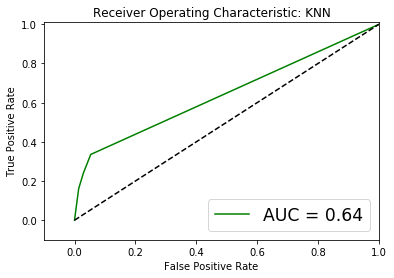

In [38]:
pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
auc_score = roc_auc_score(y_test, pred_proba)
print auc_score

plt.title('Receiver Operating Characteristic: KNN')

plt.plot(fpr, tpr, 'g',label='AUC = %0.2f'% auc_score)

plt.legend(loc='lower right', fontsize="xx-large")
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
y_test_legit = len(y_test[y_test == 0])
y_test_fraud = len(y_test[y_test == 1])

Now let's try to compare ROC curve with these classifiers: KNN, Logistic Regression, and RandomForest, each without and with SMOTE

In [104]:
# create classifiers
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=500, penalty='l1')
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=12)

# create dictionary to store values
clf_dict = {
            "knn": {"clf": knn}, 
            "lr": {"clf": lr}, "rf": {"clf": rf}}

for k,v in clf_dict.iteritems():
    # train using original dataset
    print k.upper()
    print "Without SMOTE"
    clf = clone(v['clf'])
    clf.fit(X_train, y_train)
    pred_proba = clf.predict_proba(X_test)[:,1]
    pred = clf.predict(X_test)
#     pred = [1 if y >= threshold else 0 for y in pred_proba] # adjust threshold
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    auc_score = auc(fpr, tpr)
    print "Precision: ", precision_score(y_test, pred)
    print "Recall: ", recall_score(y_test, pred)
    print "F1 Score: ", f1_score(y_test, pred)
    print "AUC: ", auc_score
    print "TP: ", tp
    print "FP: ", fp
    print "TN: ", tn
    print "FN: ", fn
    precision, recall, _ = precision_recall_curve(y_test, pred_proba)
    v['non-smote'] = {}
    v['non-smote']['fpr'] = fpr
    v['non-smote']['tpr'] = tpr
    v['non-smote']['thresholds'] = thresholds
    v['non-smote']['auc'] = auc_score
    v['non-smote']['recall'] = recall
    v['non-smote']['precision'] = precision
    # train using SMOTE
    print "With SMOTE"
    clf = clone(v['clf'])
    clf.fit(X_train_res, y_train_res)
    pred_proba = clf.predict_proba(X_test)[:,1]
    pred = clf.predict(X_test)
#     pred = [1 if y >= threshold else 0 for y in pred_proba] # adjust threshold
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
    auc_score = auc(fpr, tpr)
    print "Precision: ", precision_score(y_test, pred)
    print "Recall: ", recall_score(y_test, pred)
    print "F1 Score: ", f1_score(y_test, pred)
    print "AUC: ", auc_score
    print "TP: ", tp
    print "FP: ", fp
    print "TN: ", tn
    print "FN: ", fn
    print ""
    precision, recall, _ = precision_recall_curve(y_test, pred_proba)
    v['smote'] = {}
    v['smote']['fpr'] = fpr
    v['smote']['tpr'] = tpr
    v['smote']['thresholds'] = thresholds
    v['smote']['auc'] = auc_score
    v['smote']['recall'] = recall
    v['smote']['precision'] = precision
    

RF
Without SMOTE
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
AUC:  0.832581714155841
TP:  0
FP:  5
TN:  94673
FN:  137
With SMOTE


KeyboardInterrupt: 

In [14]:
## if it's already there
# with open('imbalance_task_result.pickle', 'rb') as handle:
#    clf_dict = pickle.load(handle)

with open('imbalance_task_result.pickle', 'wb') as handle:
    pickle.dump(clf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

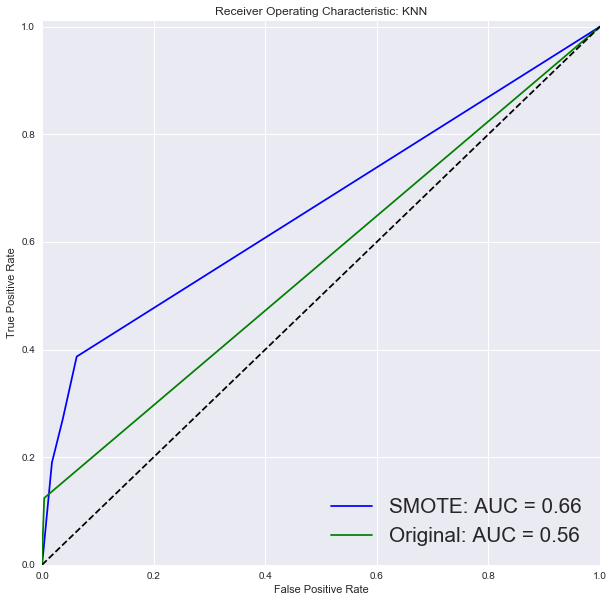

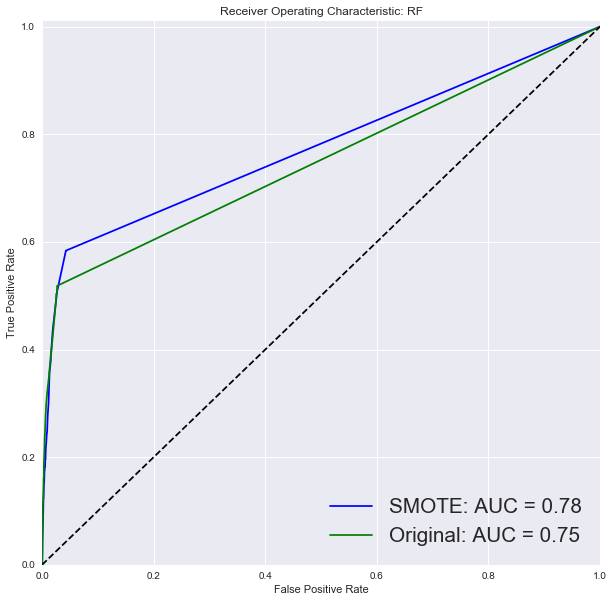

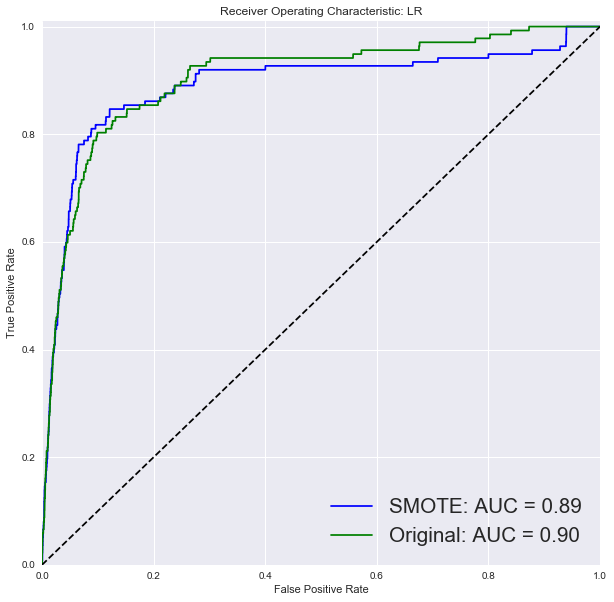

In [110]:
# plot the ROCs
for k in clf_dict.keys():
    plt.title('Receiver Operating Characteristic: ' + k.upper())

    plt.plot(clf_dict[k]['smote']['fpr'], clf_dict[k]['smote']['tpr'], 'b',label='SMOTE: AUC = %0.2f'% clf_dict[k]['smote']['auc'])
    plt.plot(clf_dict[k]['non-smote']['fpr'], clf_dict[k]['non-smote']['tpr'], 'g',label='Original: AUC = %0.2f'% clf_dict[k]['non-smote']['auc'])

    plt.legend(loc='lower right', fontsize="xx-large")
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1.0])
    plt.ylim([0,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

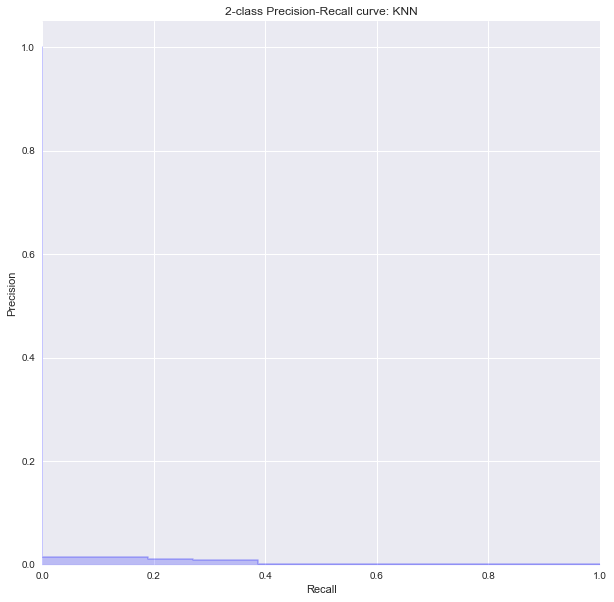

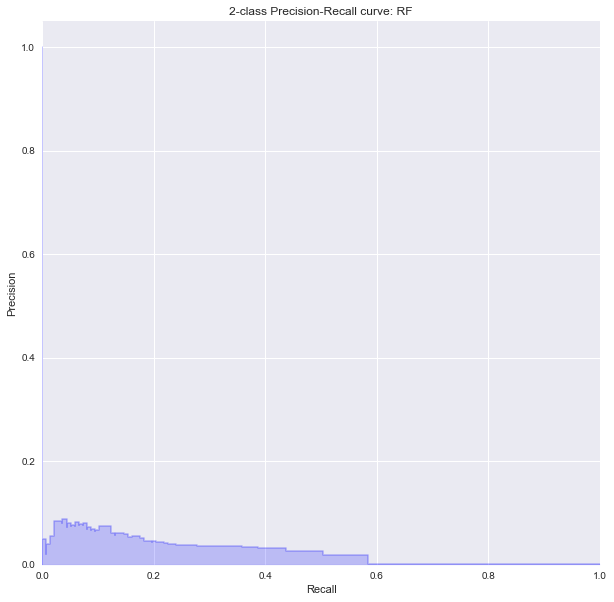

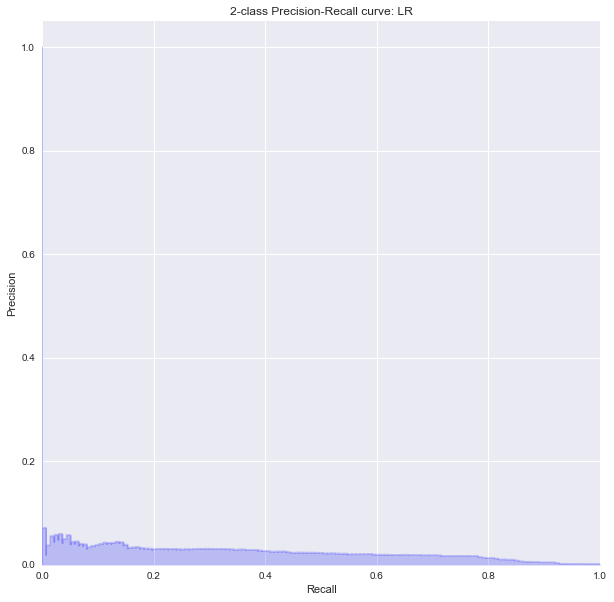

In [112]:
# plot the PR curve
for k in clf_dict.keys():
    plt.step(clf_dict[k]['smote']['recall'], clf_dict[k]['smote']['precision'], color='b', alpha=0.2,
         where='post')
    plt.fill_between(clf_dict[k]['smote']['recall'], clf_dict[k]['smote']['precision'], step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: ' + k.upper())
    plt.show()

## Classification Task

### Black-Box: Random Forest

First let's redo the preprocessing

In [86]:
temp = data_preproc.copy()
for x in data_preproc.columns:
    if data_preproc[x].dtypes == np.dtype('O'):
        temp = temp.drop([x], axis=1)
        
temp = temp.drop(['creationdate'], axis=1)
# temp = temp.drop(['bin'], axis=1)
print temp.dtypes

labels = temp['is_fraud']
temp = temp.drop(['is_fraud'], axis=1)

temp = pd.get_dummies(temp, dummy_na=True)
temp.head()

feature_names = temp.columns

labels = np.array(labels)
temp = np.array(temp)

len(feature_names)

issuercountrycode               category
txvariantcode                   category
bin                             category
amount                           float64
currencycode                    category
shoppercountrycode              category
shopperinteraction              category
cardverificationcodesupplied    category
cvcresponsecode                 category
accountcode                     category
creation_month                  category
creation_weekday                category
creation_day                    category
creation_hour                   category
amount_euro                      float64
is_fraud                        category
dtype: object


2961

Then, let's setup a stratified 10 fold split for 10-fold cross validation

Now, proceed to train RandomForest on this splits

In [87]:
def run_cross_validation(clf, data, labels, threshold=0.5, undersampling=True, ratio=0.3, apply_pca=False, verbose=False):
    all_precision = []
    all_recall = []
    all_f1 = []
    all_auc = []
    all_average_precision = []
    total_tp = 0
    total_fp = 0
    total_tn = 0
    total_fn = 0
    
    skf = StratifiedKFold(n_splits=10, random_state=13)
    pca = PCA(n_components=30)

    for train_index, test_index in skf.split(temp, labels):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        
        # apply PCA
        if apply_pca:
            pca.fit(X_train)
            X_train = pca.transform(X_train)
       

        # apply undersampling
        rus = RandomUnderSampler(ratio={0:int(((1.0 - ratio) / ratio) * len([x for x in y_train if x == 1]))}) 
        #smote = SMOTE(ratio={1: int((3/7.0) * len([x for x in y_train if x == 0]))})
        if undersampling:
            X_train_res, y_train_res = rus.fit_sample(X_train, y_train)
            clf.fit(X_train_res, y_train_res)
        else:
            clf.fit(X_train, y_train)
            
        if apply_pca:
            X_test = pca.transform(X_test)
        
        pred = clf.predict(X_test)
        pred_proba = clf.predict_proba(X_test)[:,1]
        pred = [1 if y >= threshold else 0 for y in pred_proba]


        fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
        auc_score = auc(fpr, tpr)
        average_precision = average_precision_score(y_test, pred_proba)
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
        if verbose:
            print "Precision: ", precision_score(y_test, pred)
            print "Recall: ", recall_score(y_test, pred)
            print "TP: ", tp
            print "FP: ", fp
            print "TN: ", tn
            print "FN: ", fn
            print "F1 Score: ", f1_score(y_test, pred)
            print "AUC: ", auc_score
            print "AUPRC: ", average_precision

        all_precision.append(precision_score(y_test, pred))
        all_recall.append(recall_score(y_test, pred))
        all_f1.append(f1_score(y_test, pred))
        all_auc.append(auc_score)
        all_average_precision.append(average_precision)
        total_tp = total_tp + tp
        total_fp = total_fp + fp
        total_tn = total_tn + tn
        total_fn = total_fn + fn
       
    print "----SUMMARY-----"
    print "TP: ", total_tp
    print "FP: ", total_fp
    print "TN: ", total_tn
    print "FN: ", total_fn
    print "Precision: ", np.mean(all_precision)
    print "Recall: ", np.mean(all_recall)
    print "F1: ", np.mean(all_f1)
    print "AUC: ", np.mean(all_auc)
    print "AUPRC: ", np.mean(all_average_precision)
    

In [88]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=10, random_state=12)
run_cross_validation(clf, temp, labels, threshold=0.6, verbose=True)

Precision:  0.0020475020475020475
Recall:  1.0
TP:  35
FP:  17059
TN:  6611
FN:  0
F1 Score:  0.004086636697997548
AUC:  0.6918450117689661
AUPRC:  0.002284329969271559
Precision:  0.004956629491945477
Recall:  0.8
TP:  28
FP:  5621
TN:  18048
FN:  7
F1 Score:  0.009852216748768473
AUC:  0.8698176638520548
AUPRC:  0.006334978648843157
Precision:  1.0
Recall:  1.0
TP:  35
FP:  0
TN:  23669
FN:  0
F1 Score:  1.0
AUC:  1.0
AUPRC:  1.0
Precision:  1.0
Recall:  0.8
TP:  28
FP:  0
TN:  23669
FN:  7
F1 Score:  0.888888888888889
AUC:  1.0
AUPRC:  1.0
Precision:  1.0
Recall:  0.6285714285714286
TP:  22
FP:  0
TN:  23669
FN:  13
F1 Score:  0.7719298245614035
AUC:  0.999894980172981
AUPRC:  0.9593853635882772
Precision:  1.0
Recall:  0.29411764705882354
TP:  10
FP:  0
TN:  23669
FN:  24
F1 Score:  0.45454545454545453
AUC:  0.9993886269704976
AUPRC:  0.8186263611550866
Precision:  1.0
Recall:  0.08823529411764706
TP:  3
FP:  0
TN:  23669
FN:  31
F1 Score:  0.1621621621621622
AUC:  0.99651567078307

### White-Box: Decision Tree

In [47]:
# remove identifiers
temp = data_preproc.copy()
for x in data_preproc.columns:
    if data_preproc[x].dtypes == np.dtype('O'):
        temp = temp.drop([x], axis=1)
        
temp = temp.drop(['creationdate'], axis=1)
# temp = temp.drop(['bin'], axis=1)
for column in temp.columns:
    if hasattr(temp[column], 'cat'):
        temp[column] = temp[column].cat.codes
        
labels = temp['is_fraud']
temp = temp.drop(['is_fraud'], axis=1)

feature_names = temp.columns

labels = np.array(labels)
temp = np.array(temp)


In [71]:
clf = tree.DecisionTreeClassifier(max_depth=10, random_state=12)
run_cross_validation(clf, temp, labels, threshold=0.6, verbose=True)

Precision:  0.0017683019249229526
Recall:  1.0
TP:  35
FP:  19758
TN:  3912
FN:  0
F1 Score:  0.003530361105507363
AUC:  0.5826362484157162
AUPRC:  0.0017683019249229526
Precision:  0.0010131712259371835
Recall:  0.2571428571428571
TP:  9
FP:  8874
TN:  14795
FN:  26
F1 Score:  0.002018389773491814
AUC:  0.2838661781836398
AUPRC:  0.001357449704309407
Precision:  0.016091954022988506
Recall:  0.2
TP:  7
FP:  428
TN:  23241
FN:  28
F1 Score:  0.02978723404255319
AUC:  0.20986643167977403
AUPRC:  0.0037464860756724785
Precision:  0.07692307692307693
Recall:  0.9428571428571428
TP:  33
FP:  396
TN:  23273
FN:  2
F1 Score:  0.14224137931034486
AUC:  0.9282974113216201
AUPRC:  0.05278865106880092
Precision:  0.03417533432392273
Recall:  0.6571428571428571
TP:  23
FP:  650
TN:  23019
FN:  12
F1 Score:  0.06497175141242938
AUC:  0.6991151777792531
AUPRC:  0.024135281742554943
Precision:  0.09900990099009901
Recall:  0.5882352941176471
TP:  20
FP:  182
TN:  23487
FN:  14
F1 Score:  0.169491525

In [ ]:
modelDT = tree.DecisionTreeClassifier();
modelDT = modelDT.fit(X_train, y_train)
# predict the response
pred = modelDT.predict(X_test)
# evaluate accuracy
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print ('Precision before smoting - DT', precision) #0.035398230088495575
print ('Recall before smoting - DT', recall) #0.035398230088495575
print ('Accuracy before smoting -  DT', accuracy) #0.9972130602643757

modelDT.fit(X_train_res, y_train_res)
pred = modelDT.predict(X_test)
recalldt_smoting = recall_score(y_test, pred)
precision_smoting = precision_score(y_test, pred)
accuracydt_smoting = accuracy_score(y_test, pred)

print ('Precision after smoting - DT', precision_smoting) #0.035398230088495575
print ('Recall after smoting - DT', recalldt_smoting) #0.05309734513274336
print ('Accuracy after smoting -  DT', accuracydt_smoting) #0.9967911840658639

In [72]:
#visualization of the 
modelDT = tree.DecisionTreeClassifier(max_depth=5, random_state=12)
modelDT.fit(temp, labels)

dot_data = tree.export_graphviz(modelDT, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['Legitimate', 'Fraud'],  
                         filled=True, rounded=True,  
                         special_characters=True, max_depth=5)  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree_fraud")

'decision_tree_fraud.pdf'

In [54]:
threshold = 0.6
pred = modelDT.predict(temp)
pred_proba = modelDT.predict_proba(temp)[:,1]
pred = [1 if y >= threshold else 0 for y in pred_proba]


fpr, tpr, thresholds = roc_curve(labels, pred_proba, pos_label=1)
auc_score = auc(fpr, tpr)
average_precision = average_precision_score(labels, pred_proba)
tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
print "Precision: ", precision_score(labels, pred)
print "Recall: ", recall_score(labels, pred)
print "TP: ", tp
print "FP: ", fp
print "TN: ", tn
print "FN: ", fn
print "F1 Score: ", f1_score(labels, pred)
print "AUC: ", auc_score
print "AUPRC: ", average_precision

Precision:  0.9090909090909091
Recall:  0.028985507246376812
TP:  10
FP:  1
TN:  236690
FN:  335
F1 Score:  0.056179775280898875
AUC:  0.9519598750379554
AUPRC:  0.09024618695850711


## Bonus Task - Data Aggregation

As seen in previous results, although AUC can be obtained pretty high, the classifier suffers from a really low precision which won't be acceptable in the real world. Let's try to add derived features based on context aggregated from card_id, etc.

Let's see how many days of data do we have.

In [15]:
print "Start Date: ", data_preproc.creationdate.min()
print "End Date: ", data_preproc.creationdate.max()
data_preproc.sort_values(by=["card_id","creationdate"])

Start Date:  2015-07-01 00:00:41
End Date:  2015-10-31 23:59:12


,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,creation_hour,amount_euro,is_fraud
205368,372697,GB,visadebit,465859,4370.0,GBP,GB,Ecommerce,NaN,1,...,UKAccount,email32318,ip45370,card1,10,3,8,0,4921.004921,0
222380,392860,GB,mccredit,527669,8067.0,GBP,GB,Ecommerce,True,1,...,UKAccount,email282587,ip118422,card10,10,4,16,12,9084.152562,0
71228,216605,GB,visadebit,475129,7675.0,GBP,GB,Ecommerce,True,1,...,UKAccount,email124883,ip87278,card1000,7,2,8,11,8642.726034,0
220747,390975,GB,visadebit,465901,8619.0,GBP,GB,Ecommerce,True,1,...,UKAccount,email280659,ip161323,card10000,10,2,14,18,9705.753184,0
88091,237318,GB,visadebit,465845,5395.0,GBP,GB,Ecommerce,True,1,...,UKAccount,email93952,ip118859,card100001,7,6,19,18,6075.245206,0
132251,289172,GB,mccredit,518652,5850.0,GBP,GB,Ecommerce,True,1,...,UKAccount,email257278,ip276245,card100002,8,1,18,23,6587.615283,0
194456,360269,GB,visadebit,446291,6090.0,GBP,GB,Ecommerce,True,1,...,UKAccount,email190675,ip192997,card100005,9,2,30,16,6857.876423,0
147964,307228,GB,visadebit,453978,7000.0,GBP,GB,Ecommerce,NaN,1,...,UKAccount,email210334,ip182267,card100006,8,4,28,20,7882.616578,0
49628,81391,AU,mccredit,552350,5850.0,AUD,AU,Ecommerce,True,0,...,APACAccount,email44693,ip160360,card100009,9,0,21,4,3727.301688,0
73474,219262,GB,visadebit,492181,2895.0,GBP,GB,Ecommerce,True,1,...,UKAccount,email162676,ip329623,card10001,7,3,9,22,3260.024999,0


So, it seems we have 4 months worth of transaction data. Let's calculate a derived attribute: on each row of transaction, we average amount spent on previous transaactions using the same card_id 

In [55]:
# copy the data_preproc into a new temp dataframe
temp = data_preproc.copy()

In [56]:
# group the transaction by card_id and sort by creationdate
temp.sort_values(by=["card_id","creationdate"], inplace=True)

prev_card_id = None
prev_amounts_euro = []
prev_amounts = []

ii = 0
for index, row in temp.iterrows():
    # print ii, " out of ", len(temp)
    # if current card id equals to previous card, accumulate the amount and calculate the mean
    if row['card_id'] == prev_card_id:
        # update mean
        temp.at[index, 'prev_amount_mean'] = np.mean(prev_amounts)
        temp.at[index, 'prev_transaction_count'] = len(prev_amounts)
        temp.at[index, 'prev_amount_euro_mean'] = np.mean(prev_amounts_euro)
        
        if row['is_fraud'] == 0:
            prev_amounts.append(row['amount'])
            prev_amounts_euro.append(row['amount_euro'])
    # if the card_id is a new one, reset amount list
    else:
        prev_amounts = []
        prev_amounts_euro = []
        
        temp.at[index, 'prev_amount_mean'] = 0
        temp.at[index, 'prev_transaction_count'] = 0
        temp.at[index, 'prev_amount_euro_mean'] = 0
    
    
    prev_card_id = row['card_id']
    ii = ii + 1

temp.to_csv(open("fraud_data_derived.csv", "w"))
    

Now let's calculate another derived attribute which is the number of previous transaction:
* using the same `card_id` with same `shoppercountrycode`
* using the same `card_id` with same `currencycode`
* using the same `mail_id` and `card_id`

In [57]:
def derive_transaction_count(temp, based_on=["card_id"], column_name="prev_transaction_count"):
    temp.sort_values(by=based_on + ["creationdate"], inplace=True)
    
    count = 0
    prev_values = {}
    for attr in based_on:
        prev_values[attr] = None
    ii = 0
    for index, row in temp.iterrows():
        # if current attribute group by equals to previous transaction, reset the count
        should_reset = False
        for key in prev_values.keys():
            should_reset = should_reset or row[key] != prev_values[key]
            
        if should_reset:
            count = 0

        # update transaction derived attribute
        temp.at[index, column_name] = count
        # update counter
        if row['is_fraud'] == 0:
            count = count + 1

        for key in prev_values.keys():
            prev_values[key] = row[key]
            
        ii = ii + 1
    
    temp = temp.fillna({column_name: 0}, axis = 0)
    temp[column_name] = temp[column_name].astype(int)
    temp.to_csv(open("fraud_data_derived.csv", "w"))


In [58]:
derive_transaction_count(temp, based_on=["card_id", "shoppercountrycode"], column_name="prev_transaction_count_shoppercountrycode")
temp

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,creation_month,creation_weekday,creation_day,creation_hour,amount_euro,is_fraud,prev_amount_mean,prev_transaction_count,prev_amount_euro_mean,prev_transaction_count_shoppercountrycode
205368,372697,GB,visadebit,465859,4370.0,GBP,GB,Ecommerce,NaN,1,...,10,3,8,0,4921.004921,0,0.0,0.0,0.0,0.0
222380,392860,GB,mccredit,527669,8067.0,GBP,GB,Ecommerce,True,1,...,10,4,16,12,9084.152562,0,0.0,0.0,0.0,0.0
71228,216605,GB,visadebit,475129,7675.0,GBP,GB,Ecommerce,True,1,...,7,2,8,11,8642.726034,0,0.0,0.0,0.0,0.0
220747,390975,GB,visadebit,465901,8619.0,GBP,GB,Ecommerce,True,1,...,10,2,14,18,9705.753184,0,0.0,0.0,0.0,0.0
88091,237318,GB,visadebit,465845,5395.0,GBP,GB,Ecommerce,True,1,...,7,6,19,18,6075.245206,0,0.0,0.0,0.0,0.0
132251,289172,GB,mccredit,518652,5850.0,GBP,GB,Ecommerce,True,1,...,8,1,18,23,6587.615283,0,0.0,0.0,0.0,0.0
194456,360269,GB,visadebit,446291,6090.0,GBP,GB,Ecommerce,True,1,...,9,2,30,16,6857.876423,0,0.0,0.0,0.0,0.0
147964,307228,GB,visadebit,453978,7000.0,GBP,GB,Ecommerce,NaN,1,...,8,4,28,20,7882.616578,0,0.0,0.0,0.0,0.0
49628,81391,AU,mccredit,552350,5850.0,AUD,AU,Ecommerce,True,0,...,9,0,21,4,3727.301688,0,0.0,0.0,0.0,0.0
73474,219262,GB,visadebit,492181,2895.0,GBP,GB,Ecommerce,True,1,...,7,3,9,22,3260.024999,0,0.0,0.0,0.0,0.0


In [59]:
derive_transaction_count(temp, based_on=["card_id", "currencycode"], column_name="prev_transaction_count_currencycode")
temp

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,creation_weekday,creation_day,creation_hour,amount_euro,is_fraud,prev_amount_mean,prev_transaction_count,prev_amount_euro_mean,prev_transaction_count_shoppercountrycode,prev_transaction_count_currencycode
205368,372697,GB,visadebit,465859,4370.0,GBP,GB,Ecommerce,NaN,1,...,3,8,0,4921.004921,0,0.0,0.0,0.0,0.0,0.0
222380,392860,GB,mccredit,527669,8067.0,GBP,GB,Ecommerce,True,1,...,4,16,12,9084.152562,0,0.0,0.0,0.0,0.0,0.0
71228,216605,GB,visadebit,475129,7675.0,GBP,GB,Ecommerce,True,1,...,2,8,11,8642.726034,0,0.0,0.0,0.0,0.0,0.0
220747,390975,GB,visadebit,465901,8619.0,GBP,GB,Ecommerce,True,1,...,2,14,18,9705.753184,0,0.0,0.0,0.0,0.0,0.0
88091,237318,GB,visadebit,465845,5395.0,GBP,GB,Ecommerce,True,1,...,6,19,18,6075.245206,0,0.0,0.0,0.0,0.0,0.0
132251,289172,GB,mccredit,518652,5850.0,GBP,GB,Ecommerce,True,1,...,1,18,23,6587.615283,0,0.0,0.0,0.0,0.0,0.0
194456,360269,GB,visadebit,446291,6090.0,GBP,GB,Ecommerce,True,1,...,2,30,16,6857.876423,0,0.0,0.0,0.0,0.0,0.0
147964,307228,GB,visadebit,453978,7000.0,GBP,GB,Ecommerce,NaN,1,...,4,28,20,7882.616578,0,0.0,0.0,0.0,0.0,0.0
49628,81391,AU,mccredit,552350,5850.0,AUD,AU,Ecommerce,True,0,...,0,21,4,3727.301688,0,0.0,0.0,0.0,0.0,0.0
73474,219262,GB,visadebit,492181,2895.0,GBP,GB,Ecommerce,True,1,...,3,9,22,3260.024999,0,0.0,0.0,0.0,0.0,0.0


In [60]:
derive_transaction_count(temp, based_on=["card_id", "mail_id"], column_name="prev_transaction_count_mail_id")
temp

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,creation_day,creation_hour,amount_euro,is_fraud,prev_amount_mean,prev_transaction_count,prev_amount_euro_mean,prev_transaction_count_shoppercountrycode,prev_transaction_count_currencycode,prev_transaction_count_mail_id
205368,372697,GB,visadebit,465859,4370.0,GBP,GB,Ecommerce,NaN,1,...,8,0,4921.004921,0,0.0,0.0,0.0,0.0,0.0,0.0
222380,392860,GB,mccredit,527669,8067.0,GBP,GB,Ecommerce,True,1,...,16,12,9084.152562,0,0.0,0.0,0.0,0.0,0.0,0.0
71228,216605,GB,visadebit,475129,7675.0,GBP,GB,Ecommerce,True,1,...,8,11,8642.726034,0,0.0,0.0,0.0,0.0,0.0,0.0
220747,390975,GB,visadebit,465901,8619.0,GBP,GB,Ecommerce,True,1,...,14,18,9705.753184,0,0.0,0.0,0.0,0.0,0.0,0.0
88091,237318,GB,visadebit,465845,5395.0,GBP,GB,Ecommerce,True,1,...,19,18,6075.245206,0,0.0,0.0,0.0,0.0,0.0,0.0
132251,289172,GB,mccredit,518652,5850.0,GBP,GB,Ecommerce,True,1,...,18,23,6587.615283,0,0.0,0.0,0.0,0.0,0.0,0.0
194456,360269,GB,visadebit,446291,6090.0,GBP,GB,Ecommerce,True,1,...,30,16,6857.876423,0,0.0,0.0,0.0,0.0,0.0,0.0
147964,307228,GB,visadebit,453978,7000.0,GBP,GB,Ecommerce,NaN,1,...,28,20,7882.616578,0,0.0,0.0,0.0,0.0,0.0,0.0
49628,81391,AU,mccredit,552350,5850.0,AUD,AU,Ecommerce,True,0,...,21,4,3727.301688,0,0.0,0.0,0.0,0.0,0.0,0.0
73474,219262,GB,visadebit,492181,2895.0,GBP,GB,Ecommerce,True,1,...,9,22,3260.024999,0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
temp[temp.isnull().any(axis=1)]
temp.loc[temp['is_fraud'] == 1].describe()
# temp.loc[temp['is_fraud'] == 1][['shoppercountrycode', 'currencycode', 'issuercountrycode', 'prev_amount_mean',
#                                 'prev_amount_euro_mean', 'prev_transaction_count', 'prev_transaction_count_mail_id']]

,amount,amount_euro,prev_amount_mean,prev_transaction_count,prev_amount_euro_mean,prev_transaction_count_shoppercountrycode,prev_transaction_count_currencycode,prev_transaction_count_mail_id
count,345.000000,345.000000,305.000000,345.000000,305.000000,345.000000,345.000000,345.000000
mean,105137.652174,14541.493629,729.475410,0.069565,576.925473,0.159420,0.168116,0.162319
std,124188.477258,13168.759405,3926.163533,0.390030,2842.299692,0.596092,0.605808,0.592860
min,3195.000000,1296.471343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26000.000000,5198.893447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65200.000000,8667.713094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,129900.000000,21025.804396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,769500.000000,77617.510591,28000.000000,3.000000,16891.321239,4.000000,4.000000,4.000000


Let's fill up the NaN values with 0

In [61]:
temp = temp.fillna({"prev_amount_mean": 0, "prev_amount_euro_mean": 0, "prev_transaction_count": 0}, axis=0)

In [66]:
temp_encoded = temp.copy()
for x in temp_encoded.columns:
    if temp_encoded[x].dtypes == np.dtype('O'):
        temp_encoded = temp_encoded.drop([x], axis=1)
        
temp_encoded = temp_encoded.drop(['creationdate'], axis=1)
# temp_encoded = temp_encoded.drop(['bin'], axis=1)
print temp_encoded.dtypes

labels = temp_encoded['is_fraud']
temp_encoded = temp_encoded.drop(['is_fraud'], axis=1)

temp_encoded = pd.get_dummies(temp_encoded, dummy_na=True)
temp_encoded.head()
# for column in temp_encoded.columns:
#     if hasattr(temp_encoded[column], 'cat'):
#         temp_encoded[column] = temp_encoded[column].cat.codes

feature_names = temp_encoded.columns

labels = np.array(labels)
temp_encoded = np.array(temp_encoded)

len(feature_names)

issuercountrycode                            category
txvariantcode                                category
bin                                          category
amount                                        float64
currencycode                                 category
shopperinteraction                           category
cardverificationcodesupplied                 category
cvcresponsecode                              category
accountcode                                  category
creation_month                               category
creation_weekday                             category
creation_day                                 category
creation_hour                                category
amount_euro                                   float64
is_fraud                                     category
prev_amount_mean                              float64
prev_transaction_count                        float64
prev_amount_euro_mean                         float64
prev_transaction_count_shopp

2823

In [68]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=10, random_state=12)
run_cross_validation(clf, temp_encoded, labels, threshold=0.6, verbose=True)

Precision:  0.01762977473065622
Recall:  0.5142857142857142
TP:  18
FP:  1003
TN:  22667
FN:  17
F1 Score:  0.03409090909090909
AUC:  0.9431468404852436
AUPRC:  0.0174835414152507
Precision:  0.02182952182952183
Recall:  0.6
TP:  21
FP:  941
TN:  22728
FN:  14
F1 Score:  0.04212637913741224
AUC:  0.9339292504360737
AUPRC:  0.026501870934684157
Precision:  0.02081268582755203
Recall:  0.6
TP:  21
FP:  988
TN:  22681
FN:  14
F1 Score:  0.040229885057471264
AUC:  0.9238714895312132
AUPRC:  0.04253934483194713
Precision:  0.02541436464088398
Recall:  0.6571428571428571
TP:  23
FP:  882
TN:  22787
FN:  12
F1 Score:  0.04893617021276596
AUC:  0.9295431637524671
AUPRC:  0.03423275445638015
Precision:  0.026078234704112337
Recall:  0.7428571428571429
TP:  26
FP:  971
TN:  22698
FN:  9
F1 Score:  0.050387596899224806
AUC:  0.9611764634875032
AUPRC:  0.025854960447793986
Precision:  0.023350253807106598
Recall:  0.6764705882352942
TP:  23
FP:  962
TN:  22707
FN:  11
F1 Score:  0.0451422963689892

In [26]:
temp.card_id.value_counts()

card14995     114
card124850    106
card170983    106
card11998      73
card162548     54
card183189     54
card18592      52
card26166      41
card85020      36
card248277     35
card18996      30
card117396     30
card62220      28
card24826      24
card95543      23
card225611     22
card134054     21
card261540     20
card183042     20
card218899     19
card63597      18
card60173      18
card90280      17
card67685      17
card64933      17
card4579       16
card214376     16
card68114      16
card160961     15
card176976     15
             ... 
card36064       1
card113466      1
card188559      1
card31023       1
card113467      1
card90275       1
card106848      1
card37339       1
card234088      1
card227278      1
card234086      1
card234087      1
card234084      1
card234083      1
card234080      1
card234081      1
card38804       1
card159710      1
card234089      1
card243628      1
card181388      1
card181389      1
card218269      1
card181386      1
card181387

In [27]:
temp.loc[(temp['is_fraud'] == 1)]['card_id'].value_counts()
temp.loc[temp['card_id'] == 'card158982'].sort_values(by='creationdate')

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,...,creation_day,creation_hour,amount_euro,is_fraud,prev_amount_mean,prev_transaction_count,prev_amount_euro_mean,prev_transaction_count_shoppercountrycode,prev_transaction_count_currencycode,prev_transaction_count_mail_id
227949,399224,GB,mccredit,528683,4395.0,GBP,GB,Ecommerce,True,1,...,21,20,4949.157123,0,0.0,0.0,0.0,0.0,0.0,0.0
58653,195198,GB,mccredit,528683,9395.0,GBP,GB,ContAuth,False,0,...,21,21,10579.597536,1,0.0,0.0,0.0,1.0,1.0,1.0
58654,195400,GB,mccredit,528683,13000.0,GBP,GB,ContAuth,False,0,...,22,9,14639.145074,1,0.0,0.0,0.0,1.0,1.0,1.0
58655,195487,GB,mccredit,528683,12500.0,GBP,GB,ContAuth,False,0,...,22,14,14076.101033,1,0.0,0.0,0.0,1.0,1.0,1.0
58656,195698,GB,mccredit,528683,11000.0,GBP,GB,ContAuth,False,0,...,23,0,12386.968909,1,0.0,0.0,0.0,1.0,1.0,1.0
58658,195798,GB,mccredit,528683,5595.0,GBP,GB,ContAuth,False,0,...,23,11,6300.462822,1,0.0,0.0,0.0,1.0,1.0,1.0
